# Environment Setup

In [ ]:
# Install necessary Python dependencies

# Document parsing & Google Drive API
!pip install -q python-docx google-api-python-client

# Hugging Face Transformers & supporting utilities
!pip install -q transformers accelerate huggingface_hub sentencepiece

# Retrieval & similarity search
!pip install -q rank-bm25 faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 6.9 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries

# Standard library
import os, io, time, re, json, hashlib
from json import JSONDecodeError
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict, List

# Scientific / data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Documents
from docx import Document

# Google Colab & Drive API
from google.colab import auth, userdata
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload, MediaFileUpload

# Hugging Face / Transformers / Torch
from huggingface_hub import login
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch

# Retrieval / Embeddings
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer
import faiss


# Data Synchronization

In [ ]:
# [Config]
# ---------------------------------------------------------------------
# Central configuration controlling Drive sync and preprocessing stages.
# - UPDATE_JSONL: True to scan Drive .docx and update JSONL. False to only load JSONL.
# - RUN_BASELINE_PREPROCESSING: Run baseline text/people preprocessing pipeline.
# - RUN_RAG_PREPROCESSING: Run RAG pipeline (LLM analysis, chunking, embeddings).
# ---------------------------------------------------------------------

UPDATE_JSONL               = False  # True: update JSONL with new .docx; False: load JSONL only
RUN_BASELINE_PREPROCESSING = False  # Baseline preprocessing (split, people, roles, metadata)
RUN_RAG_PREPROCESSING      = False  # RAG preprocessing (LLMs, chunking, embeddings)
AUTO_SHUTDOWN_AFTER_RUN    = True   # Set to False to keep runtime alive

# Google Drive folder and filenames
DATABASE_FOLDER_ID     = "1AxyCDytXdUViBaOAT5dyQbOmbECIqS4C"
DATABASE_FILENAME      = "database_df.jsonl"
CHUNKS_FILENAME        = "chunks.jsonl"
DEMBEDDINGS_FILENAME   = "dense_embeddings.npy"
FAISS_FILENAME         = "faiss.index"

In [ ]:
# [Drive Client]
# ---------------------------------------------------------------------
# Handles Google Drive authentication and client creation.
# Provides a single reusable `_drive()` helper for Drive API v3 calls.
# ---------------------------------------------------------------------

def _drive():
  """Authenticate Colab user and create a Drive v3 service client.

  Returns:
    googleapiclient.discovery.Resource:
      Authenticated Drive API service.

  Raises:
    RuntimeError: If authentication or client initialisation fails.
  """
  try:
    auth.authenticate_user()                       # Prompt user for Colab OAuth
    creds = GoogleCredentials.get_application_default()
    return build("drive", "v3", credentials=creds)  # Return Drive service handle
  except Exception as e:
    raise RuntimeError("Drive auth/client init failed.") from e

In [ ]:
# [Drive File I/O Helpers]
# ---------------------------------------------------------------------
# Collection of helpers for file discovery, listing, downloading, and
# uploading JSONL documents in Google Drive.  All network operations
# are wrapped in try/except to provide clear RuntimeErrors on failure.
# ---------------------------------------------------------------------

def _find_file(drive, folder_id: str, name: str):
  """Search for a file by exact name within a Drive folder.

  Args:
    drive: Drive API client from `_drive()`.
    folder_id (str): Folder ID to search.
    name (str): Exact filename.

  Returns:
    str | None: File ID if found, otherwise None.
  """
  try:
    q = f"'{folder_id}' in parents and trashed=false and name='{name}'"
    res = drive.files().list(q=q, fields="files(id,name)", pageSize=1).execute()
    files = res.get("files", [])
    return files[0]["id"] if files else None
  except Exception as e:
    raise RuntimeError(f"Search failed for '{name}' in folder {folder_id}.") from e

def _list_docx(drive, folder_id: str):
  """List all `.docx` files within a Drive folder.

  Args:
    drive: Drive API client.
    folder_id (str): Folder ID.

  Returns:
    list[dict]: Each element has `id` and `name`.
  """
  try:
    q = (
      f"'{folder_id}' in parents and trashed=false and "
      "mimeType='application/vnd.openxmlformats-officedocument.wordprocessingml.document'"
    )
    out, token = [], None
    while True:
      res = drive.files().list(
        q=q,
        pageToken=token,
        pageSize=1000,
        fields="nextPageToken,files(id,name)"
      ).execute()
      out.extend(res.get("files", []))
      token = res.get("nextPageToken")
      if not token:
        break
    return out
  except Exception as e:
    raise RuntimeError(f"Listing .docx failed for folder {folder_id}.") from e

def _download_file_to_bytes(drive, file_id: str) -> bytes:
  """Download a Drive file directly into memory.

  Args:
    drive: Drive API client.
    file_id (str): File ID.

  Returns:
    bytes: Raw file content.
  """
  try:
    req = drive.files().get_media(fileId=file_id)
    buf = io.BytesIO()
    downloader = MediaIoBaseDownload(buf, req)
    done = False
    while not done:
      _, done = downloader.next_chunk()
    return buf.getvalue()
  except Exception as e:
    raise RuntimeError(f"Download failed for file {file_id}.") from e

def _download_file_to_path(drive, file_id: str, path: str):
  """Download a Drive file to the Colab filesystem.

  Args:
    drive: Drive API client.
    file_id (str): File ID.
    path (str): Destination path.
  """
  try:
    req = drive.files().get_media(fileId=file_id)
    with open(path, "wb") as fh:
      downloader = MediaIoBaseDownload(fh, req)
      done = False
      while not done:
        _, done = downloader.next_chunk()
  except Exception as e:
    raise RuntimeError(f"Download failed for file {file_id} → {path}.") from e

def _upload_jsonl(drive, folder_id: str, file_id: str, local_path: str):
  """Upload or update the JSONL database file to Drive.

  Args:
    drive: Drive API client.
    folder_id (str): Destination folder ID.
    file_id (str): Existing file ID (if any).
    local_path (str): Local JSONL path to upload.
  """
  try:
    media = MediaFileUpload(local_path, mimetype="application/json", resumable=False)
    if file_id:
      drive.files().update(fileId=file_id, media_body=media).execute()
    else:
      drive.files().create(
        body={"name": DATABASE_FILENAME, "parents": [folder_id], "mimeType": "application/json"},
        media_body=media
      ).execute()
  except Exception as e:
    raise RuntimeError(f"Upload failed for '{local_path}'.") from e

In [ ]:
# [JSONL & DOCX Helpers]
# ---------------------------------------------------------------------
# Pure local utilities for reading/writing JSONL files and extracting
# text from Word (.docx) documents.  No network side effects.
# ---------------------------------------------------------------------

def _read_jsonl_df(path: str) -> pd.DataFrame:
  """Load a JSONL file into a DataFrame.

  - Ensures required columns exist.
  - Falls back to manual line-by-line parsing if pandas fails.

  Args:
    path (str): Local path to JSONL file.

  Returns:
    pd.DataFrame: Always includes 'filename', 'content', 'preprocessed'.
  """
  if not os.path.exists(path):
    return pd.DataFrame(columns=["filename", "content", "preprocessed"])
  try:
    df = pd.read_json(path, orient="records", lines=True, dtype=False)
  except ValueError:
    rows = []
    with open(path, "r", encoding="utf-8") as f:
      for line in f:
        s = line.strip()
        if not s:
          continue
        try:
          rows.append(json.loads(s))
        except JSONDecodeError:
          continue
    df = pd.DataFrame(rows)
  for col in ("filename", "content", "preprocessed"):
    if col not in df.columns:
      df[col] = None
  return df

def _docx_to_text(docx_bytes: bytes) -> str:
  """Convert a `.docx` byte stream into plain text.

  Args:
    docx_bytes (bytes): Raw Word file content.

  Returns:
    str: Paragraphs joined by newlines.
  """
  try:
    doc = Document(io.BytesIO(docx_bytes))
    return "\n".join(p.text for p in doc.paragraphs if p.text)
  except Exception as e:
    raise RuntimeError("DOCX parse failed.") from e

def _write_jsonl_atomic(df: pd.DataFrame, path: str):
  """Safely write a DataFrame to disk as JSONL.

  - Writes to a temporary file first.
  - Replaces target atomically to prevent corruption.

  Args:
    df (pd.DataFrame): DataFrame to save.
    path (str): Destination path.
  """
  tmp = f"{path}.tmp"
  try:
    df.to_json(tmp, orient="records", lines=True, force_ascii=False)
    os.replace(tmp, path)
  except Exception as e:
    if os.path.exists(tmp):
      try:
        os.remove(tmp)
      except Exception:
        pass
    raise RuntimeError(f"JSONL write failed: {e}") from e

In [ ]:
# [Core Flows]
# ---------------------------------------------------------------------
# High-level orchestration functions to update or load the database.
# ---------------------------------------------------------------------

def update_database():
  """Synchronise Drive folder → local JSONL → Drive JSONL.

  Steps:
    1) List all `.docx` files in Drive.
    2) Load existing JSONL if present.
    3) Prune rows for deleted files.
    4) Append new files (extract text).
    5) Upload updated JSONL back to Drive.

  Returns:
    pd.DataFrame: Updated table sorted by filename desc.
  """
  drive = _drive()
  local_tmp = f"/content/{DATABASE_FILENAME}"

  docx = _list_docx(drive, DATABASE_FOLDER_ID)
  jsonl_id = _find_file(drive, DATABASE_FOLDER_ID, DATABASE_FILENAME)

  if not docx and not jsonl_id:
    return pd.DataFrame(columns=["filename", "content", "preprocessed"])

  if jsonl_id:
    _download_file_to_path(drive, jsonl_id, local_tmp)
  df = _read_jsonl_df(local_tmp)
  changed = False

  current_names = {f["name"] for f in docx}

  # --- Prune ---
  if not df.empty:
    to_prune_mask = df["filename"].notna() & ~df["filename"].isin(current_names)
    pruned = int(to_prune_mask.sum())
    if pruned > 0:
      df = df[~to_prune_mask].copy()
      changed = True
      print(f"[info] Pruned {pruned} row(s) not present in Drive.")

  # --- Append ---
  existing = set(df["filename"].dropna()) if not df.empty else set()
  missing = [f for f in docx if f["name"] not in existing]
  if missing:
    new_rows = []
    for f in missing:
      try:
        b = _download_file_to_bytes(drive, f["id"])
        txt = _docx_to_text(b)
        new_rows.append({"filename": f["name"], "content": txt, "preprocessed": np.nan})
      except Exception as e:
        print(f"[warn] Skipping '{f['name']}': {e}")
    if new_rows:
      df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
      df = df.drop_duplicates(subset=["filename"], keep="last")
      changed = True
      print(f"[info] Added {len(new_rows)} new file(s).")

  # --- Write back ---
  if changed or not jsonl_id:
    if not df.empty:
      df = df.sort_values(by="filename", ascending=False).reset_index(drop=True)
    _write_jsonl_atomic(df, local_tmp)
    _upload_jsonl(drive, DATABASE_FOLDER_ID, jsonl_id, local_tmp)

  return df

def load_database():
  """Load the current Drive JSONL into a DataFrame.

  Returns:
    pd.DataFrame: Database sorted by filename desc.

  Raises:
    FileNotFoundError: If the JSONL file does not exist in Drive.
  """
  drive = _drive()
  local_tmp = f"/content/{DATABASE_FILENAME}"

  jsonl_id = _find_file(drive, DATABASE_FOLDER_ID, DATABASE_FILENAME)
  if not jsonl_id:
    raise FileNotFoundError(
      f"'{DATABASE_FILENAME}' not found in the shared folder. Run update mode first."
    )

  _download_file_to_path(drive, jsonl_id, local_tmp)
  df = _read_jsonl_df(local_tmp)
  if not df.empty:
    df = df.sort_values(by="filename", ascending=False).reset_index(drop=True)
  return df

In [ ]:
# [Entrypoint]
# ---------------------------------------------------------------------
# Single entrypoint to run in update or load mode based on UPDATE_JSONL.
# ---------------------------------------------------------------------

database_df = update_database() if UPDATE_JSONL else load_database()

In [ ]:
# Visualise Database
database_df.head(100)

,filename,content,preprocessed,text_blocks
0,HSBC_2025_Q1_Earnings_Call.docx,"HSBC Holdings plc, Q1 2025 Earnings Call, Apr ...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Welcome, ladies..."
1,HSBC_2024_Q4_Earnings_Call.docx,"HSBC Holdings plc, 2024 Earnings Call, Feb 19,...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Ladies and gent..."
2,HSBC_2024_Q3_Earnings_Call.docx,"HSBC Holdings plc, Q3 2024 Earnings Call, Oct ...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Welcome, ladies..."
3,HSBC_2024_Q2_Earnings_Call.docx,"HSBC Holdings plc, H1 2024 Earnings Call, Jul ...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Welcome, ladies..."
4,HSBC_2024_Q1_Earnings_Call.docx,"HSBC Holdings plc, Q1 2024 Earnings Call, Apr ...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Welcome, ladies..."
5,HSBC_2023_Q4_Earnings_Call.docx,"HSBC Holdings plc, 2023 Earnings Call, Feb 21,...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Good morning, g..."
6,HSBC_2023_Q3_Earnings_Call.docx,"HSBC Holdings plc, Q3 2023 Earnings Call, Oct ...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Good morning, l..."
7,HSBC_2023_Q2_Earnings_Call.docx,"HSBC Holdings plc, Q2 2023 Earnings Call, Aug ...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Good morning, l..."
8,HSBC_2023_Q1_Earnings_Call.docx,"HSBC Holdings plc, Q1 2023 Earnings Call, May ...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Good morning, l..."
9,HSBC_2022_Q4_Earnings_Call.docx,"HSBC Holdings plc, 2022 Earnings Call, Feb 21,...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Good morning, l..."


In [ ]:
# Visualise first document
database_df.iloc[0, 2]

[{'type': 'answer',
  'person_type': 'presenter',
  'name': 'Georges Elhedery',
  'text': "Welcome all to today's call. I'm joined here in London by Pam. Before Pam takes you through the numbers, I would like to begin with some opening remarks. Overall, there was a strong quarter marked by three key drivers: momentum in our earnings, discipline in our execution, and confidence in our ability to deliver our targets.\nFirst, we have strong momentum in our business. We had a strong first quarter with profit before tax up 11% and an annualized return on tangible equity of 18.4%, both excluding notable items.\nWe had our fifth consecutive quarter of double-digit growth in Wealth and attracted net new invested assets of $22 billion as well as another 300,000 new-to-bank customers in Hong Kong, continuing the trend from last year. We also had a strong performance in Transaction Banking, in particular, in FX. And our equities and debt trading businesses, benefiting from higher client activity 

# Preprocessing Pipeline



## Text Normalization

In [ ]:
# [Constants]
# ---------------------------------------------------------------------
# Regular-expression patterns and constants used across the splitter.
# ---------------------------------------------------------------------

# Section-like titles to ignore as speaker headers
SECTION_LIKE = re.compile(
  r"(?:Q&A|Question\s*&\s*Answer|Forward[-\s]Looking|Overview|Agenda|Highlights|"
  r"Presentation|Prepared\s+Remarks|Safe\s+Harbor|Disclaimer)$",
  re.I
)

# Patterns for speaker header detection
# "Name:" header line on its own
NAME_COLON_RE   = re.compile(r"^([^\W\d_]+(?:['’‘-][^\W\d_]+)?(?:\s+[^\W\d_]+(?:['’‘-][^\W\d_]+)?) {0,4})\s*:\s*$", re.UNICODE)
# "Name — text" (em dash or hyphen acts like inline header + first sentence)
EMDASH_INLINE_RE = re.compile(r"^([^\W\d_]+(?:['’‘-][^\W\d_]+)?(?:\s+[^\W\d_]+(?:['’‘-][^\W\d_]+)?){0,4})\s+[—–-]\s+(.*)$", re.UNICODE)
# Header-only name (line with just a plausible human name)
HEADER_NAME_RE  = re.compile(r"^[^\W\d_]+(?:['’‘-][^\W\d_]+)?(?:\s+[^\W\d_]+(?:['’‘-][^\W\d_]+)?){0,4}$", re.UNICODE)
# Literal "Operator" headers, optionally with parentheses, optional colon
OPERATOR_LINE_RE = re.compile(r"^\s*Operator(?:\s*\(.*\))?\s*[:]*\s*$", re.I)
# Q:/A: lines
QA_LINE_RE      = re.compile(r"^(Q|A)\s*[:\-]\s*(.*)$", re.I)

In [ ]:
# [Cleaning Helper]
# ---------------------------------------------------------------------
# Light normalisation while preserving paragraph structure.
# ---------------------------------------------------------------------

def _clean_text_loose_for_split(text: str) -> str:
  """
  Normalize line endings and drop only obvious noise:
    - 'page N' footers/headers
    - URL lines
  We KEEP blank lines and all other content to preserve paragraph structure.
  """
  t = re.sub(r"\r\n?", "\n", text or "")
  out = []
  for ln in t.split("\n"):
    s = ln.strip()
    if not s:
      out.append(ln)  # keep empty line
      continue
    # Strip page markers ("page 3" or "page 3 of 10")
    if re.fullmatch(r"page\s+\d+(\s*of\s*\d+)?", s, re.I):
      continue
    # Drop naked URLs (prevents header confusion)
    if re.search(r"https?://|www\.", s, re.I):
      continue
    out.append(ln)
  return "\n".join(out)

In [ ]:
# [Splitter Core]
# ---------------------------------------------------------------------
# Convert a raw transcript into [{"name": <header>, "text": <body>}].
# ---------------------------------------------------------------------

def split_raw_blocks(text: str):
  """
  Robust minimalist splitter:
    Input  : raw transcript (string)
    Output : list of {"name": <header>, "text": <body>} blocks

  Behavior:
    - Starts a new block when we see:
        * 'Name:'   (NAME_COLON_RE)
        * 'Name — ' (EMDASH_INLINE_RE)
        * header-only 'Name' on its own (HEADER_NAME_RE)
        * 'Operator' (OPERATOR_LINE_RE)
        * 'Q:'/'A:'  (QA_LINE_RE) -> name='Analyst'/'Management'
    - Skips obvious section headers via SECTION_LIKE.
    - Ignores any preamble text before the first detected header.
    - Preserves internal blank lines within blocks.
    - Trims trailing/leading whitespace from names and block bodies.
    - Drops empty bodies (no zero-length blocks returned).
  """
  if not text:
    return []

  # Light clean while preserving structure
  t = _clean_text_loose_for_split(text)
  lines = t.split("\n")

  blocks = []               # final: list of {"name":..,"text":..}
  cur_name, cur_body = None, []
  seen_first_header = False # ignore any content until we detect the very first header

  def flush():
    """Finish the current block and append it to `blocks` (if non-empty)."""
    nonlocal cur_name, cur_body, seen_first_header
    if not seen_first_header:
      # If we never saw a header yet, any accumulated content is preamble -> discard.
      cur_name, cur_body = None, []
      return
    body = "\n".join(cur_body).strip()
    if cur_name and body:
      blocks.append({"name": cur_name.strip(), "text": body})
    # reset
    cur_name, cur_body = None, []

  for ln in lines:
    s = ln.strip()

    # Keep blank lines inside the current block as paragraph breaks.
    if s == "":
      if cur_name is not None:
        cur_body.append("")  # preserve blank line inside a block
      continue

    # Try patterns in decreasing specificity
    m_qa = QA_LINE_RE.match(s)              # "Q: ..." / "A: ..."
    m_nc = NAME_COLON_RE.match(s)           # "Name:"
    m_em = EMDASH_INLINE_RE.match(s)        # "Name — text"
    m_op = OPERATOR_LINE_RE.match(s)        # "Operator" (variants)
    m_nm = HEADER_NAME_RE.match(s)          # header-only "Name"

    if m_qa:
      # Start a new Q/A block as its own speaker.
      flush(); seen_first_header = True
      role = m_qa.group(1).upper()
      tail = m_qa.group(2).strip()
      cur_name = "Analyst" if role == "Q" else "Management"
      cur_body = [tail] if tail else []
      continue

    if m_nc:
      # "Name:" line = start new block
      nm = m_nc.group(1).strip()
      # Avoid false positives for section headings
      if SECTION_LIKE.search(nm):
        if cur_name is not None:
          cur_body.append(s)
        continue
      flush(); seen_first_header = True
      cur_name = nm; cur_body = []
      continue

    if m_em:
      # "Name — text": start a new block with 'text' as the first line
      nm  = m_em.group(1).strip()
      txt = m_em.group(2).strip()
      if SECTION_LIKE.search(nm):
        if cur_name is not None:
          cur_body.append(s)
        continue
      flush(); seen_first_header = True
      cur_name = nm; cur_body = [txt] if txt else []
      continue

    if m_op:
      # Literal operator header line
      flush(); seen_first_header = True
      cur_name = "Operator"; cur_body = []
      continue

    if m_nm and len(s) <= 60 and not SECTION_LIKE.search(s):
      # Header-only name line (e.g., "Noel Quinn")
      flush(); seen_first_header = True
      cur_name = s; cur_body = []
      continue

    # Otherwise: regular content line, add to current block if any header is active.
    if cur_name is None:
      # Still in preamble (no header seen yet) -> ignore line.
      continue
    cur_body.append(s)

  # Close the last block
  flush()

  # Final guard: drop any empties (shouldn't have any)
  return [b for b in blocks if b.get("name") and b.get("text")]

In [ ]:
if RUN_BASELINE_PREPROCESSING:
  # [Apply Splitter & Write Back]
  # ---------------------------------------------------------------------
  # Apply the splitter row-wise and write the result back to the original
  # variable name to keep downstream cells compatible.
  # ---------------------------------------------------------------------

  database_df["text_blocks"] = database_df["content"].apply(split_raw_blocks)

In [ ]:
if RUN_BASELINE_PREPROCESSING:
  # [Sanity Peek]
  # ---------------------------------------------------------------------
  # Terse summary and a tiny peek at the first split for quick QA.
  # ---------------------------------------------------------------------

  n_rows = len(database_df)
  n_empty = int((database_df["text_blocks"].apply(len) == 0).sum())
  print(f"✅ Added 'text_blocks' to database_df: {n_rows} rows (empty splits: {n_empty}).")

  try:
    peek = database_df.loc[database_df["text_blocks"].apply(len) > 0, ["filename", "text_blocks"]].head(1)
    if not peek.empty:
        first = peek.iloc[0]
        first_chunk_name = first["text_blocks"][0].get("name", "<none>") if first["text_blocks"] else "<none>"
        print(f"   e.g., first row '{first.get('filename', '<no filename>')}' starts with speaker: {first_chunk_name}")
  except Exception:
    pass

In [ ]:
database_df

,filename,content,preprocessed,text_blocks
0,HSBC_2025_Q1_Earnings_Call.docx,"HSBC Holdings plc, Q1 2025 Earnings Call, Apr ...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Welcome, ladies..."
1,HSBC_2024_Q4_Earnings_Call.docx,"HSBC Holdings plc, 2024 Earnings Call, Feb 19,...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Ladies and gent..."
2,HSBC_2024_Q3_Earnings_Call.docx,"HSBC Holdings plc, Q3 2024 Earnings Call, Oct ...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Welcome, ladies..."
3,HSBC_2024_Q2_Earnings_Call.docx,"HSBC Holdings plc, H1 2024 Earnings Call, Jul ...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Welcome, ladies..."
4,HSBC_2024_Q1_Earnings_Call.docx,"HSBC Holdings plc, Q1 2024 Earnings Call, Apr ...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Welcome, ladies..."
5,HSBC_2023_Q4_Earnings_Call.docx,"HSBC Holdings plc, 2023 Earnings Call, Feb 21,...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Good morning, g..."
6,HSBC_2023_Q3_Earnings_Call.docx,"HSBC Holdings plc, Q3 2023 Earnings Call, Oct ...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Good morning, l..."
7,HSBC_2023_Q2_Earnings_Call.docx,"HSBC Holdings plc, Q2 2023 Earnings Call, Aug ...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Good morning, l..."
8,HSBC_2023_Q1_Earnings_Call.docx,"HSBC Holdings plc, Q1 2023 Earnings Call, May ...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Good morning, l..."
9,HSBC_2022_Q4_Earnings_Call.docx,"HSBC Holdings plc, 2022 Earnings Call, Feb 21,...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Good morning, l..."


In [ ]:
database_df.iloc[0,2]

[{'type': 'answer',
  'person_type': 'presenter',
  'name': 'Georges Elhedery',
  'text': "Welcome all to today's call. I'm joined here in London by Pam. Before Pam takes you through the numbers, I would like to begin with some opening remarks. Overall, there was a strong quarter marked by three key drivers: momentum in our earnings, discipline in our execution, and confidence in our ability to deliver our targets.\nFirst, we have strong momentum in our business. We had a strong first quarter with profit before tax up 11% and an annualized return on tangible equity of 18.4%, both excluding notable items.\nWe had our fifth consecutive quarter of double-digit growth in Wealth and attracted net new invested assets of $22 billion as well as another 300,000 new-to-bank customers in Hong Kong, continuing the trend from last year. We also had a strong performance in Transaction Banking, in particular, in FX. And our equities and debt trading businesses, benefiting from higher client activity 

Top 100 speaker names:
                      name  count  firm position  role
0                 Operator    425  None     None  None
1              Iain Mackay    315  None     None  None
2           Ewen Stevenson    298  None     None  None
3               Noel Quinn    282  None     None  None
4          Stuart Gulliver    150  None     None  None
5         Georges Elhedery    135  None     None  None
6               Raul Sinha     67  None     None  None
7         Richard O'Connor     63  None     None  None
8           Manus Costello     56  None     None  None
9               John Flint     50  None     None  None
10    Thomas Andrew Rayner     40  None     None  None
11             Ronit Ghose     36  None     None  None
12        Joseph Dickerson     35  None     None  None
13          Martin Leitgeb     31  None     None  None
14             Aman Rakkar     28  None     None  None
15           Thomas Rayner     28  None     None  None
16           Guy Stebbings     27  None   

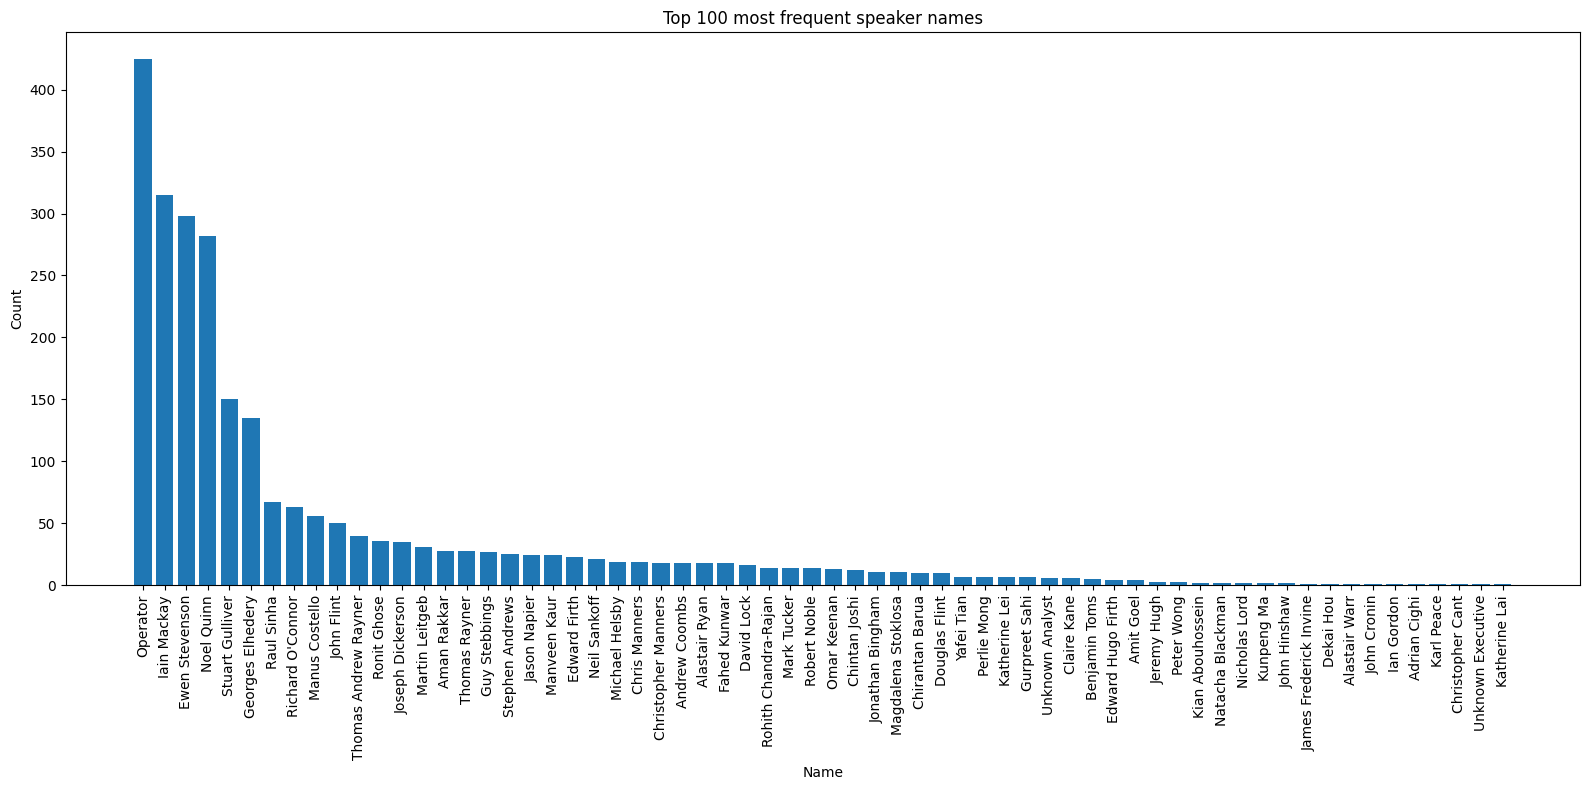

In [ ]:
if RUN_BASELINE_PREPROCESSING:
  # [Identify All Speakers]
  # ---------------------------------------------------------------------
  # Identify all unique speaker names across transcript blocks.
  # Produces a frequency table (people_df) and a bar chart of the most
  # frequent speakers.
  # ---------------------------------------------------------------------

  def collect_speaker_counts(df: pd.DataFrame) -> dict[str, int]:
    """Aggregate all speaker names and their frequencies from text_blocks.

      Args:
        df (pd.DataFrame): DataFrame containing a 'text_blocks' column,
          where each row is a list of {"name": ..., "text": ...} dicts.

      Returns:
        dict[str, int]: Mapping of speaker name → occurrence count.
    """
    name_counts = {}
    for _, row in df.iterrows():
      blocks = row.get("text_blocks", [])
      if not isinstance(blocks, list):
        continue
      for block in blocks:
        nm = (block.get("name") or "").strip()
        if not nm:
          continue
        name_counts[nm] = name_counts.get(nm, 0) + 1
    return name_counts

  # ---------------------------------------------------------------------
  # Extract and count speaker names
  # ---------------------------------------------------------------------
  name_counts = collect_speaker_counts(database_df)

  # Build DataFrame and add metadata placeholders
  people_df = (
    pd.DataFrame([{"name": k, "count": v} for k, v in name_counts.items()])
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
  )
  people_df["firm"] = None
  people_df["position"] = None
  people_df["role"] = None

  print("✅ Speaker extraction complete.")
  print(f"Total unique names found: {len(people_df)}")

  # ---------------------------------------------------------------------
  # Display top results and plot chart
  # ---------------------------------------------------------------------
  top_n = 100
  print(f"\nTop {top_n} speaker names:")
  pd.set_option("display.max_rows", None)
  print(people_df.head(top_n))

  plt.figure(figsize=(16, 8))
  plt.bar(people_df["name"].head(top_n), people_df["count"].head(top_n))
  plt.xticks(rotation=90)
  plt.xlabel("Speaker Name")
  plt.ylabel("Count")
  plt.title(f"Top {top_n} Most Frequent Speakers")
  plt.tight_layout()
  plt.show()

In [ ]:
if RUN_BASELINE_PREPROCESSING:
  # [Identify All Operators]
  # ---------------------------------------------------------------------
  # Identify all transcript participants who act as Operators.
  # Looks for the pattern "[Operator Instructions]" inside block text,
  # prints sample matches, updates their role in people_df, and displays them.
  # ---------------------------------------------------------------------

  # Regex pattern to detect "[Operator Instructions]" blocks
  OP_INSTR_RE = re.compile(r"\[\s*Operator Instructions?\s*\]", re.I)

  # ---------------------------------------------------------------------
  # Scan all transcripts for operator mentions
  # ---------------------------------------------------------------------
  unique_names = set()

  for _, row in database_df.iterrows():
    fname = row.get("filename", "<no filename>")
    text_blocks = row.get("text_blocks", [])
    if not isinstance(text_blocks, list):
      continue

    for block in text_blocks:
      name = (block.get("name") or "").strip()
      text = (block.get("text") or "").strip()

      if OP_INSTR_RE.search(text):
        print("=" * 80)
        print(f"📄 File: {fname}")
        print(f"👤 Name: {name}")
        print("📝 Text:")
        print(text)
        print()
        unique_names.add(name)

  # ---------------------------------------------------------------------
  # Summarise and update people_df
  # ---------------------------------------------------------------------
  print("\n✅ Additional people acting as operators:")
  for nm in sorted(unique_names):
    print(nm)

  mask = people_df["name"].isin(unique_names)
  people_df.loc[mask, "firm"] = "HSBC"
  people_df.loc[mask, "role"] = "Operator"

  print("\n✅ Operators:")
  display(people_df.loc[mask].sort_values("name"))

📄 File: HSBC_2025_Q1_Earnings_Call.docx
👤 Name: Operator
📝 Text:
Thank you, Pam. [Operator Instructions] Our first question today comes from Benjamin Toms at RBC.

📄 File: HSBC_2024_Q4_Earnings_Call.docx
👤 Name: Neil Sankoff
📝 Text:
Let's take a couple from the Zoom, and then we'll come back with Kunpeng and Jeremy. So we'll take our first question from Kian Abouhossein from JPMorgan. [Operator Instructions]

📄 File: HSBC_2024_Q3_Earnings_Call.docx
👤 Name: Operator
📝 Text:
[Operator Instructions] Our first question today comes from Andrew Coombs at Citigroup.

📄 File: HSBC_2024_Q2_Earnings_Call.docx
👤 Name: Operator
📝 Text:
Thank you, Georges. [Operator Instructions] Our first question today comes from Andrew Coombs at Citigroup.

📄 File: HSBC_2024_Q2_Earnings_Call.docx
👤 Name: Operator
📝 Text:
[Operator Instructions] Our next question today comes from Aman Rakkar at Barclays.

📄 File: HSBC_2024_Q1_Earnings_Call.docx
👤 Name: Operator
📝 Text:
[Operator instructions] Our first question t

,name,count,firm,position,role
21,Neil Sankoff,21,HSBC,None,Operator
0,Operator,425,HSBC,None,Operator
7,Richard O'Connor,63,HSBC,None,Operator


In [ ]:
if RUN_BASELINE_PREPROCESSING:
  # [Identify All Presenters]
  # ---------------------------------------------------------------------
  # Extract names of presenters (non-Operator speakers) from each transcript.
  # Logic:
  #   1) Build the set of Operator names from people_df (role == 'Operator'),
  #      plus the generic label "Operator".
  #   2) For each file, detect the "presentation segment":
  #        - If the transcript starts with an Operator, presentation is from
  #          the first non-Operator block until the next Operator (if any).
  #        - Otherwise, presentation is from the very start until the first
  #          Operator (if any).
  #   3) Collect distinct non-Operator names within that segment per file.
  #   4) Update people_df for identified presenters (firm='HSBC', role='presenter').
  # Notes:
  #   - Uses only double-space indentation.
  #   - Adds docstrings and comments without changing the working logic.
  # ---------------------------------------------------------------------

  # ---- Build the Operator name set from people_df (role == 'Operator') ----
  if "role" not in people_df.columns or "name" not in people_df.columns:
    raise ValueError("people_df must have 'name' and 'role' columns.")

  operator_names = set(
    people_df.loc[
      people_df["role"].astype(str).str.strip().str.casefold() == "operator",
      "name"
    ].astype(str).str.strip()
  )

  # As a safety net, include the generic 'Operator' label
  operator_names.update({"Operator"})

  def _is_operator_by_people_df(name: str) -> bool:
    """Return True if the given name is recognised as an Operator.

    Args:
      name (str): Speaker name as extracted from a block header.

    Returns:
      bool: True if name is in the precomputed operator_names set; False otherwise.
    """
    return (name or "").strip() in operator_names

  # ---- Per-file extraction following the defined logic ----
  per_file_names = {}   # {filename: [distinct names in segment]}
  global_unique = set()

  for _, row in database_df.iterrows():
    fname = row.get("filename", "<no filename>")
    blocks = row.get("text_blocks", [])
    if not isinstance(blocks, list) or not blocks:
      continue

    # Determine segment start and end
    starts_with_operator = _is_operator_by_people_df((blocks[0].get("name") or "").strip())

    if starts_with_operator:
      # Start AFTER the first operator (index 0)
      seg_start = 1
      # End at the next operator after index 0
      seg_end = len(blocks)
      for j in range(1, len(blocks)):
        nm_j = (blocks[j].get("name") or "").strip()
        if _is_operator_by_people_df(nm_j):
          seg_end = j
          break
    else:
      # Start at the very beginning
      seg_start = 0
      # End at the first operator anywhere
      seg_end = len(blocks)
      for j in range(0, len(blocks)):
        nm_j = (blocks[j].get("name") or "").strip()
        if _is_operator_by_people_df(nm_j):
          seg_end = j
          break

    # Collect distinct non-Operator names within [seg_start, seg_end)
    seen = set()
    names_segment = []
    for k in range(seg_start, seg_end):
      nm = (blocks[k].get("name") or "").strip()
      if nm and (not _is_operator_by_people_df(nm)) and nm not in seen:
        seen.add(nm)
        names_segment.append(nm)

    # Save if any found
    if names_segment:
      per_file_names[fname] = names_segment
      global_unique.update(names_segment)

  # ---- Output ----
  print("\n✅ Presenters:")
  for nm in sorted(global_unique):
    print(nm)

  # Update firm/role for the extracted names
  mask = people_df["name"].isin(global_unique)
  people_df.loc[mask, "firm"] = "HSBC"
  people_df.loc[mask, "role"] = "presenter"

  print("\n✅ Presenters:")
  display(people_df.loc[mask].sort_values("name"))


✅ Presenters:
Douglas Flint
Ewen Stevenson
Georges Elhedery
Iain Mackay
John Flint
John Hinshaw
Jonathan Bingham
Manveen Kaur
Mark Tucker
Noel Quinn
Peter Wong
Stuart Gulliver

✅ Presenters:


,name,count,firm,position,role
37,Douglas Flint,10,HSBC,None,presenter
2,Ewen Stevenson,298,HSBC,None,presenter
5,Georges Elhedery,135,HSBC,None,presenter
1,Iain Mackay,315,HSBC,None,presenter
9,John Flint,50,HSBC,None,presenter
53,John Hinshaw,2,HSBC,None,presenter
34,Jonathan Bingham,11,HSBC,None,presenter
19,Manveen Kaur,24,HSBC,None,presenter
30,Mark Tucker,14,HSBC,None,presenter
3,Noel Quinn,282,HSBC,None,presenter


In [ ]:
# [Fill Remaining Roles and Positions]
# ---------------------------------------------------------------------
# Final normalisation of the people_df DataFrame:
#   1) Any undefined role is set to "participant".
#   2) Any undefined position (for participants only) is set to "Analyst".
# This ensures consistent labelling for all speakers downstream.
# ---------------------------------------------------------------------

# Fill missing roles
people_df["role"] = people_df["role"].fillna("participant")

# Fill missing positions for participants
mask = people_df["role"] == "participant"
people_df.loc[mask, "position"] = people_df.loc[mask, "position"].fillna("Analyst")

print("✅ Normalised remaining speaker roles and positions.")
display(people_df.head(10))

Blocks per person:


,blocks
name_canon,
Unknown Executive,1



Total words per person:


,total_words
name_canon,
Unknown Executive,1



Per-file counts (pivot):


name_canon,Unknown Executive
filename,
HSBC_2017_Q4_Earnings_Call.docx,1


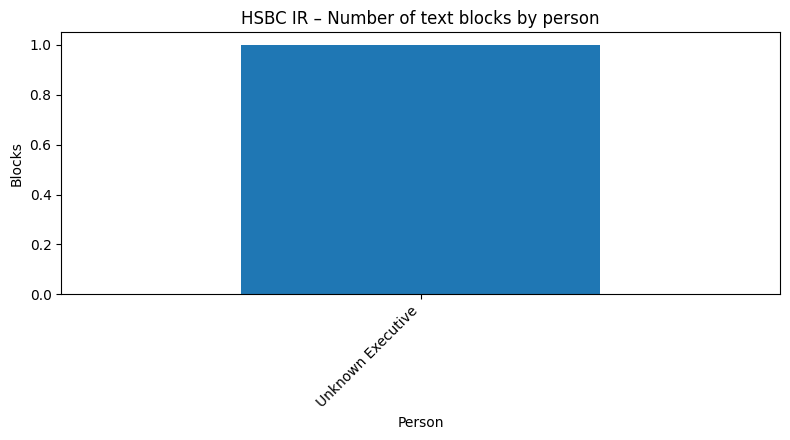

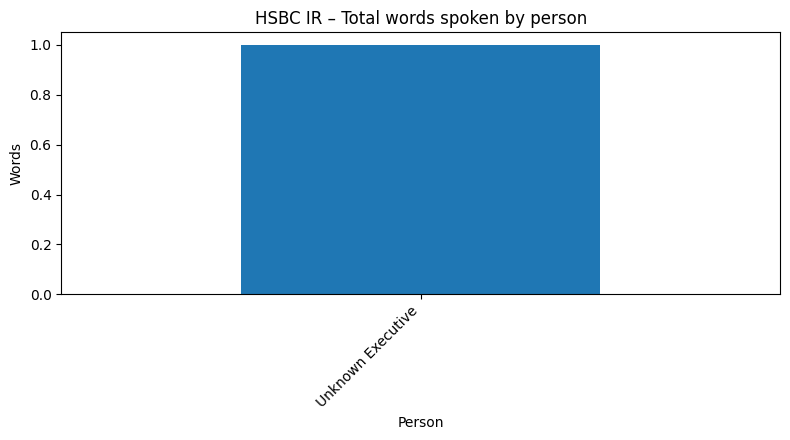


Sample IR blocks (first 10):


,filename,block_index,name,name_canon,text,chars,words
0,HSBC_2017_Q4_Earnings_Call.docx,51,Unknown Executive,Unknown Executive,[indiscernible].,16,1


In [ ]:
if RUN_BASELINE_PREPROCESSING:
  # [Find IR People With No/Low Participation]
  # ---------------------------------------------------------------------
  # Scans transcript blocks to locate appearances of a curated list of IR
  # (Investor Relations) people and summarises their participation:
  #   - Blocks per person
  #   - Total words per person
  #   - Per-file pivot table
  # Also prints a small sample of matching blocks for inspection.
  # ---------------------------------------------------------------------

  # ---- Config: IR people (canonical names) ----
  IR_PEOPLE = [
    "Unknown Executive"
  ]

  def _is_match(name: str, target: str) -> bool:
    """Return True if `name` matches `target` ignoring case and extra spaces.

    Args:
      name (str): Name extracted from a transcript block.
      target (str): Canonical name from IR_PEOPLE.

    Returns:
      bool: True if equal after strip().lower(), else False.
    """
    return (name or "").strip().lower() == target.strip().lower()

  # ---- Collect matching blocks into rows ----
  rows = []
  for _, row in database_df.iterrows():
    fname = row.get("filename", "<no filename>")
    blocks = row.get("text_blocks", []) or []
    if not isinstance(blocks, list):
      continue

    for idx, blk in enumerate(blocks):
      name = (blk.get("name") or "").strip()
      text = (blk.get("text") or "").strip()
      if not name or not text:
        continue

      # Check against our IR list
      for canon in IR_PEOPLE:
        if _is_match(name, canon):
          rows.append({
            "filename": fname,
            "block_index": idx,
            "name": name,         # original in transcript
            "name_canon": canon,  # normalised to our list
            "text": text,
            "chars": len(text),
            "words": len(text.split()),
          })
          break

  ir_df = pd.DataFrame(rows)

  # ---- Summarise and visualise (guard for empty) ----
  if ir_df.empty:
    print("No IR text blocks found for the specified people.")
  else:
    # Summary tables
    counts = ir_df["name_canon"].value_counts().sort_values(ascending=False)
    words_per_person = ir_df.groupby("name_canon")["words"].sum().sort_values(ascending=False)

    print("Blocks per person:")
    display(counts.to_frame("blocks"))

    print("\nTotal words per person:")
    display(words_per_person.to_frame("total_words"))

    print("\nPer-file counts (pivot):")
    pivot_counts = ir_df.pivot_table(
      index="filename",
      columns="name_canon",
      values="block_index",
      aggfunc="count",
      fill_value=0
    )
    display(pivot_counts)

    # Plot 1: blocks per person
    plt.figure(figsize=(8, 4.5))
    counts.plot(kind="bar")
    plt.title("HSBC IR - Number of text blocks by person")
    plt.ylabel("Blocks")
    plt.xlabel("Person")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Plot 2: total words per person
    plt.figure(figsize=(8, 4.5))
    words_per_person.plot(kind="bar")
    plt.title("HSBC IR - Total words spoken by person")
    plt.ylabel("Words")
    plt.xlabel("Person")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Optional: inspect a few matching blocks
    print("\nSample IR blocks (first 10):")
    display(ir_df.head(10))

In [ ]:
if RUN_BASELINE_PREPROCESSING:
  # [Find Firms for Analysts]
  # ---------------------------------------------------------------------
  # Extract likely firm affiliations for analysts from transcript text by:
  #   1) Building the set of analyst names from people_df.
  #   2) Scanning their blocks for self-identification patterns
  #      (e.g., "I'm Alice from Contoso").
  #   3) Falling back to previous-block handover patterns
  #      (e.g., "First question comes from Alice at Contoso").
  #   4) Aggregating results, summarising counts, computing per-analyst mode,
  #      and updating people_df (analysts with missing firm only).
  # ---------------------------------------------------------------------

  # ===============================================
  # Helpers
  # ===============================================
  def _norm_space(s: str) -> str:
    """Normalise whitespace (collapse runs to single spaces; strip ends)."""
    return re.sub(r"\s+", " ", (s or "").strip())

  def _sentences(text: str) -> list[str]:
    """Split text into coarse sentences, preserving capital-start heuristics."""
    if not text:
      return []
    t = _norm_space(text)
    parts = re.split(r"(?<=[.!?])\s+(?=[A-Z0-9])", t)
    return [p.strip() for p in parts if p.strip()]

  def _esc_name(name: str) -> str:
    """Escape a speaker name for use in regex and wrap in word boundaries."""
    nm = _norm_space(name)
    nm = re.escape(nm)
    nm = re.sub(r"\\\s+", r"\\s+", nm)  # allow flexible whitespace in name
    return rf"\b{nm}\b"

  def _clean_firm(s: str | None) -> str | None:
    """Lightly clean a firm string and drop generic suffixes (research/team/etc.)."""
    if not s:
      return None
    f = s.strip(" -\t.:;()[]").strip()
    f = re.sub(r"\s+", " ", f)
    f = re.sub(r"\s+(?:research|team|analyst|division|group)\b.*$", "", f, flags=re.I)
    return f if 2 <= len(f) <= 120 else None

  # ===============================================
  # Analyst name set from people_df
  # ===============================================
  if "role" not in people_df.columns or "position" not in people_df.columns:
    raise ValueError("people_df must have 'role' and 'position' columns.")

  analyst_mask = (
    people_df["role"].astype(str).str.lower().eq("participant") |
    people_df["position"].astype(str).str.lower().eq("analyst")
  )

  ANALYST_NAMES = set(
    people_df.loc[analyst_mask, "name"].dropna().astype(str).str.strip()
  )

  if not ANALYST_NAMES:
    raise ValueError("No analysts found in people_df (role='Participant' or position='Analyst').")

  # ===============================================
  # Scan transcripts only for those analysts
  # ===============================================
  rows = []

  for _, row in database_df.iterrows():
    filename = row.get("filename", "")
    blocks = row.get("text_blocks", [])
    if not isinstance(blocks, list):
      continue

    for i, blk in enumerate(blocks):
      speaker = _norm_space(blk.get("name", ""))
      if not speaker or speaker not in ANALYST_NAMES:
        continue

      text = blk.get("text", "") or ""
      sents = _sentences(text)[:2] or [text]

      firm = evidence = source = None
      name_pat = _esc_name(speaker)

      # -----------------------------------------------
      # Self-identification patterns (current block)
      # -----------------------------------------------
      self_patterns = [
        re.compile(rf"\b(?:it['’]s|this\s+is|i['’]?m)\s+{name_pat}\s+(?:from|at|with|of)\s+([^,.;\n]+)", re.I),
        re.compile(rf"{name_pat}\s+(?:from|at|with|of)\s+([^,.;\n]+)", re.I),
      ]
      for sent in sents:
        for rx in self_patterns:
          m = rx.search(sent)
          if m:
            firm = _clean_firm(m.group(1))
            evidence = sent
            source = "self_id_current_block"
            break
        if firm:
          break

      # -------------------------------------------------
      # Previous block handover patterns (fallback)
      # -------------------------------------------------
      if not firm and i - 1 >= 0:
        prev_text = (blocks[i - 1].get("text") or "")
        if prev_text:
          handover_patterns = [
            re.compile(rf"(?:first\s+question|initial\s+question|question(?:s)?\s+(?:now\s+)?comes\s+from)\s+{name_pat}(?:\s+(?:at|from|with|of)\s+([^,.;\n]+))?", re.I),
            re.compile(rf"(?:over\s+to|hand(?:ing)?\s+over\s+to|we'\s?ll\s+go\s+to)\s+(?:mr\.|ms\.\s+)?{name_pat}(?:\s+(?:at|from|with|of)\s+([^,.;\n]+))?", re.I),
            re.compile(rf"{name_pat}\s+(?:at|from|with|of)\s+([^,.;\n]+)", re.I),
          ]
          for rx in handover_patterns:
            m = rx.search(prev_text)
            if m:
              firm = _clean_firm(m.group(1)) if (m.lastindex and m.group(1)) else None
              evidence = _norm_space(m.group(0))
              source = "previous_block_handover"
              break

      rows.append({
        "filename": filename,
        "block_index": i,
        "name": speaker,
        "firm_guess": firm,
        "evidence": evidence,
        "source": source
      })

  # ===============================================
  # Build long DataFrame and filter to rows with firm
  # ===============================================
  affils_long_df = pd.DataFrame(rows)
  affils_long_df = affils_long_df[affils_long_df["firm_guess"].notna()].copy()

  # ===============================================
  # Mentions per firm (analysts only)
  # ===============================================
  firm_counts = affils_long_df["firm_guess"].value_counts().sort_values(ascending=False)
  print("📊 Analyst firm mentions (firm → blocks with firm detected):")
  display(firm_counts.to_frame("mentions"))

  # ===============================================
  # Most common firm per analyst (mode)
  # ===============================================
  def _mode_nonnull(s: pd.Series):
    """Return the most frequent non-null value in a Series (or None)."""
    s = s.dropna()
    return s.value_counts().idxmax() if not s.empty else None

  analyst_firm_modes = (
    affils_long_df.groupby("name", dropna=False)["firm_guess"]
    .apply(_mode_nonnull)
    .dropna()
  )

  print("\n👤 Per-analyst firm (mode):")
  display(analyst_firm_modes.to_frame("firm_mode"))

  # ===============================================
  # Update people_df (fill firm where empty, analysts only)
  # ===============================================
  if "firm" not in people_df.columns:
    people_df["firm"] = None

  update_mask = analyst_mask & people_df["firm"].isna()
  to_update = people_df.loc[update_mask, "name"].astype(str).str.strip()

  name_to_firm = analyst_firm_modes.to_dict()
  people_df.loc[update_mask, "firm"] = to_update.map(name_to_firm)

  print("\n✅ Updated people_df (analysts with newly filled firm):")
  display(
    people_df.loc[
      update_mask & people_df["firm"].notna(),
      ["name", "firm", "position", "role"]
    ].sort_values("name")
  )

📊 Analyst firm mentions (firm → blocks with firm detected):


,mentions
firm_guess,
JPMorgan,36
Barclays,26
Goldman Sachs,24
Autonomous,23
Jefferies,18
Bank of America,18
Citigroup,16
Deutsche Bank,14
Morgan Stanley,11



👤 Per-analyst firm (mode):


,firm_mode
name,
Adrian Cighi,Crédit Suisse
Alastair Ryan,Bank of America
Alastair Warr,Autonomous
Aman Rakkar,Barclays
Amit Goel,Mediobanca
Andrew Coombs,Citi
Benjamin Toms,RBC
Chintan Joshi,Nomura
Chris Manners,Morgan Stanley



✅ Updated people_df (analysts with newly filled firm):


,name,firm,position,role
59,Adrian Cighi,Crédit Suisse,None,participant
26,Alastair Ryan,Bank of America,None,participant
56,Alastair Warr,Autonomous,None,participant
14,Aman Rakkar,Barclays,None,participant
46,Amit Goel,Mediobanca,None,participant
25,Andrew Coombs,Citi,None,participant
44,Benjamin Toms,RBC,None,participant
33,Chintan Joshi,Nomura,None,participant
23,Chris Manners,Morgan Stanley,None,participant
43,Claire Kane,Crédit Suisse,None,participant


In [ ]:
if RUN_BASELINE_PREPROCESSING:
  # [Find Positions for Presenters]
  # ---------------------------------------------------------------------
  # Extract likely positions/titles for speakers labelled as Presenters.
  # Strategy:
  #   1) Build the set of presenters from people_df.
  #   2) Search presenter blocks for self-introduction patterns
  #      (e.g., "I'm <Name>, <Title>").
  #   3) Fall back to previous-block handovers that introduce a presenter
  #      (e.g., "Welcome <Name>, <Title>").
  #   4) Canonicalise titles (CEO/CFO/etc.), summarise mentions, and
  #      update people_df['position'] (by default only when empty).
  # ---------------------------------------------------------------------

  def _norm_space(s: str) -> str:
    """Collapse whitespace and strip ends."""
    return re.sub(r"\s+", " ", (s or "").strip())

  def _sentences(text: str) -> list[str]:
    """Coarse sentence splitter based on punctuation followed by caps/digits."""
    if not text:
      return []
    t = _norm_space(text)
    parts = re.split(r"(?<=[.!?])\s+(?=[A-Z0-9])", t)
    return [p.strip() for p in parts if p.strip()]

  def _esc_name(name: str) -> str:
    """Escape a name for regex and allow flexible internal whitespace."""
    nm = _norm_space(name)
    nm = re.escape(nm)
    nm = re.sub(r"\\\s+", r"\\s+", nm)
    return rf"\b{nm}\b"

  # --- title canon & gating ---
  TITLE_CANON = [
    (r"\bgroup\s+chief\s+executive\b",           "Group CEO"),
    (r"\bchief\s+executive\s+officer\b",         "CEO"),
    (r"\bgroup\s+ceo\b",                         "Group CEO"),
    (r"\bceo\b",                                 "CEO"),

    (r"\bgroup\s+chief\s+financial\s+officer\b", "Group CFO"),
    (r"\bchief\s+financial\s+officer\b",         "CFO"),
    (r"\bgroup\s+cfo\b",                         "Group CFO"),
    (r"\bcfo\b",                                 "CFO"),

    (r"\bchief\s+operating\s+officer\b",         "COO"),
    (r"\bcoo\b",                                 "COO"),

    (r"\bchief\s+risk\s+(?:and\s+)?compliance\s+officer\b", "Chief Risk & Compliance Officer"),
    (r"\bchief\s+risk\s+officer\b",              "CRO"),
    (r"\bcro\b",                                 "CRO"),

    (r"\bgroup\s+chair(?:man|woman)?\b",         "Group Chairman"),
    (r"\bchair(?:man|woman)?\b",                 "Chairman"),

    (r"\bgeneral\s+counsel\b",                   "General Counsel"),
    (r"\bgroup\s+treasurer\b",                   "Group Treasurer"),
    (r"\btreasurer\b",                           "Treasurer"),

    # Business / region
    (r"\bceo[, ]+\s*(wealth\s*&\s*personal\s*banking|wpb)\b", "CEO, Wealth & Personal Banking"),
    (r"\bceo[, ]+\s*(commercial\s*banking|cmb)\b",            "CEO, Commercial Banking"),
    (r"\bceo[, ]+\s*(global\s*banking\s*&\s*markets|gbm)\b",  "CEO, Global Banking & Markets"),
    (r"\bceo[, ]+\s*(asia[- ]?pacific|apac)\b",               "Regional CEO, Asia-Pacific"),
    (r"\bceo[, ]+\s*(europe|emea)\b",                         "Regional CEO, Europe"),
    (r"\bceo[, ]+\s*(americas)\b",                            "Regional CEO, Americas"),
  ]
  TITLE_RX = [(re.compile(p, re.I), canon) for p, canon in TITLE_CANON]

  # Hard keyword gate: candidate text must include at least one of these
  TITLE_KEYWORDS = re.compile(
    r"\b(ceo|cfo|coo|cro|chair|chairman|chairwoman|chief|officer|counsel|treasurer|head\s+of|global\s+head|director\s+of)\b",
    re.I
  )

  def _normalize_title(raw: str | None) -> str | None:
    """Clean and canonicalise a raw title phrase."""
    if not raw:
      return None
    t = _norm_space(raw)
    # remove trailing org reference
    t = re.sub(r"\s+(?:at|with|of)\s+.+$", "", t, flags=re.I)
    # gate by keywords to kill random chatter
    if not TITLE_KEYWORDS.search(t):
      return None
    # canon mappings
    for rx, canon in TITLE_RX:
      if rx.search(t):
        return canon
    # keep only reasonable length
    t = re.sub(r"\s+", " ", t)
    return t if 2 <= len(t) <= 100 else None

  def _self_title_patterns(name_pattern: str):
    """Regex patterns for self-intros like 'I'm <Name>, <Title>'."""
    return [
      re.compile(rf"\b(?:it['’]s|this\s+is|i['’]?m|i\s+am)\s+{name_pattern}\s*,\s*(.+?)(?:[.;,]|$)", re.I),
      re.compile(rf"{name_pattern}\s*,\s*(.+?)(?:[.;,]|$)", re.I),
      re.compile(rf"{name_pattern}\s*\(\s*(.+?)\s*\)", re.I),
      re.compile(rf"{name_pattern}\s*[-–—]\s*(.+?)(?:[.;,]|$)", re.I),
    ]

  def _handover_title_patterns(name_pattern: str):
    """Regex patterns for host/operator handovers naming a title."""
    return [
      re.compile(rf"(?:over\s+to|hand(?:ing)?\s+over\s+to|we'\s?ll\s+go\s+to|welcome|joined\s+by)\s+(?:our\s+)?(.+?)\s*,\s*{name_pattern}\b", re.I),
      re.compile(rf"(?:welcome|with\s+us|joined\s+by)\s+{name_pattern}\s*,\s*(.+?)\b(?:[.;,]|$)", re.I),
      re.compile(rf"{name_pattern}\s*,\s*(?:our\s+)?(.+?)\b(?:[.;,]|$)", re.I),
      re.compile(rf"\bour\s+(.+?)\s+{name_pattern}\b", re.I),
    ]

  # -------- run over Presenters and build counts --------
  presenter_mask = people_df["role"].astype(str).str.lower().eq("presenter")
  PRESENTER_NAMES = set(people_df.loc[presenter_mask, "name"].dropna().astype(str).str.strip())

  rows = []
  for _, row in database_df.iterrows():
    fname = row.get("filename", "")
    blocks = row.get("text_blocks", [])
    if not isinstance(blocks, list):
      continue

    for i, blk in enumerate(blocks):
      speaker = _norm_space(blk.get("name", ""))
      if speaker not in PRESENTER_NAMES:
        continue

      text = blk.get("text", "") or ""
      sents = _sentences(text)[:2] or [text]
      name_pat = _esc_name(speaker)

      position = evidence = source = None

      # 1) self intro within current block
      for rx in _self_title_patterns(name_pat):
        hit = None
        for sent in sents:
          m = rx.search(sent)
          if m:
            cand = _normalize_title(m.group(1))
            if cand:
              hit = (cand, sent)
              break
        if hit:
          position, evidence = hit[0], _norm_space(hit[1])
          source = "self_id"
          break

      # 2) previous block handover (fallback)
      if not position and i - 1 >= 0:
        prev_text = (blocks[i - 1].get("text") or "")
        for rx in _handover_title_patterns(name_pat):
          m = rx.search(prev_text)
          if m:
            cand = _normalize_title(m.group(1))
            if cand:
              position, evidence = cand, _norm_space(m.group(0))
              source = "handover_prev"
              break

      if position:
        rows.append({
          "filename": fname,
          "block_index": i,
          "name": speaker,
          "position_guess": position,
          "evidence": evidence,
          "source": source
        })

  pos_long_df = pd.DataFrame(rows)

  # Person × Position mentions (strict)
  person_pos_counts = (
    pos_long_df
    .groupby(["name", "position_guess"], dropna=False)
    .size()
    .reset_index(name="mentions")
    .sort_values(["name", "mentions"], ascending=[True, False])
  )

  print("👤 Person × Position mentions (STRICT):")
  display(person_pos_counts)

  # Pick most-mentioned position per presenter (mode)
  top_position_per_person = (
    person_pos_counts
    .sort_values(["name", "mentions"], ascending=[True, False])
    .groupby("name", as_index=False)
    .first()[["name", "position_guess", "mentions"]]
    .rename(columns={"position_guess": "position_mode", "mentions": "position_mode_mentions"})
  )

  print("\n🏆 Most-mentioned position per presenter (STRICT):")
  display(top_position_per_person)

  # Update people_df['position'] (only empties by default)
  UPDATE_ONLY_EMPTY = True
  if "position" not in people_df.columns:
    people_df["position"] = None

  if UPDATE_ONLY_EMPTY:
    update_mask = presenter_mask & people_df["position"].isna()
  else:
    update_mask = presenter_mask

  name_to_pos = dict(zip(top_position_per_person["name"], top_position_per_person["position_mode"]))
  people_df.loc[update_mask, "position"] = (
    people_df.loc[update_mask, "name"].astype(str).str.strip().map(name_to_pos)
  )

  print("\n✅ Updated people_df (presenters with cleaned positions):")
  display(people_df.loc[presenter_mask, ["name", "position", "role"]].sort_values("name").head(100))

👤 Person × Position mentions (STRICT):


,name,position_guess,mentions
0,Douglas Flint,Group Chairman,5
1,Ewen Stevenson,Group CFO,4
2,Georges Elhedery,Group CEO,2
3,Georges Elhedery,Group CFO,1
4,John Flint,Group CEO,4
5,Mark Tucker,Group Chairman,2
6,Noel Quinn,Group CEO,11
9,Stuart Gulliver,Group CEO,7
7,Stuart Gulliver,Chief Executive,1
8,Stuart Gulliver,Chief Group Executive,1



🏆 Most-mentioned position per presenter (STRICT):


,name,position_mode,position_mode_mentions
0,Douglas Flint,Group Chairman,5
1,Ewen Stevenson,Group CFO,4
2,Georges Elhedery,Group CEO,2
3,John Flint,Group CEO,4
4,Mark Tucker,Group Chairman,2
5,Noel Quinn,Group CEO,11
6,Stuart Gulliver,Group CEO,7



✅ Updated people_df (presenters with cleaned positions):


,name,position,role
37,Douglas Flint,Group Chairman,presenter
2,Ewen Stevenson,Group CFO,presenter
5,Georges Elhedery,Group CEO,presenter
1,Iain Mackay,NaN,presenter
9,John Flint,Group CEO,presenter
53,John Hinshaw,NaN,presenter
34,Jonathan Bingham,NaN,presenter
19,Manveen Kaur,NaN,presenter
30,Mark Tucker,Group Chairman,presenter
3,Noel Quinn,Group CEO,presenter


In [ ]:
if RUN_BASELINE_PREPROCESSING:
  # [Format People DataFrame]
  # ---------------------------------------------------------------------
  # Final cleanup and schema enforcement for people_df:
  #   1) Ensure `count` is stored as an integer column.
  #   2) Convert all other columns to string dtype and replace NaN/None with "".
  # This guarantees a clean, export-ready structure.
  # ---------------------------------------------------------------------

  # 1) Ensure `count` is integer
  people_df["count"] = pd.to_numeric(people_df["count"], errors="coerce").fillna(0).astype(int)

  # 2) Convert all other columns to string dtype and fill missing values
  str_cols = [c for c in people_df.columns if c != "count"]
  people_df[str_cols] = people_df[str_cols].astype("string").fillna("")

  print("✅ people_df formatted and normalised:")
  display(people_df.head(10))

In [ ]:
people_df

,name,count,firm,position,role
0,Operator,425,HSBC,,Operator
1,Iain Mackay,315,HSBC,,presenter
2,Ewen Stevenson,298,HSBC,Group CFO,presenter
3,Noel Quinn,282,HSBC,Group CEO,presenter
4,Stuart Gulliver,150,HSBC,Group CEO,presenter
5,Georges Elhedery,135,HSBC,Group CEO,presenter
6,Raul Sinha,67,JPMorgan,,participant
7,Richard O'Connor,63,HSBC,,Operator
8,Manus Costello,56,Autonomous,,participant
9,John Flint,50,HSBC,Group CEO,presenter


In [ ]:
if RUN_BASELINE_PREPROCESSING:
  # [Create Preprocessed Text]
  # ---------------------------------------------------------------------
  # Convert raw text_blocks into a simplified, role-based structure:
  #   - Drops "Operator" segments entirely.
  #   - Converts presenter segments → type: "answer".
  #   - Converts participant segments → type: "query".
  #   - Skips blocks with missing or unrecognised roles.
  # The resulting list of dicts is stored in database_df["preprocessed"].
  # ---------------------------------------------------------------------

  # --- Build lookup from people_df ---
  # (Assumes people_df has columns: name, role)
  _role_map = dict(
    zip(
      people_df["name"].astype(str).str.strip(),
      people_df["role"].astype(str).str.strip()
    )
  )

  def _transform_blocks(raw_blocks, role_map):
    """Transform transcript blocks into simplified role-based schema.

    Args:
      raw_blocks (list[dict]): List of {"name": str, "text": str} entries.
      role_map (dict[str, str]): Mapping of name → role from people_df.

    Returns:
      list[dict]: Filtered and normalised transcript blocks with schema:
        {
          "type": "answer" | "query",
          "person_type": "presenter" | "participant",
          "name": <speaker name>,
          "text": <spoken text>
        }
    """
    if not isinstance(raw_blocks, list):
      return []

    out = []
    for blk in raw_blocks:
      name = (blk.get("name") or "").strip()
      text = (blk.get("text") or "").strip()
      if not name or not text:
        continue

      role = role_map.get(name)
      if role == "Operator":
        # Drop operators entirely
        continue
      elif role == "presenter":
        out.append({
          "type": "answer",
          "person_type": "presenter",
          "name": name,
          "text": text
        })
      elif role == "participant":
        out.append({
          "type": "query",
          "person_type": "participant",
          "name": name,
          "text": text
        })
      else:
        # Name not in people_df (or role missing) -> skip
        continue

    return out

  # --- Apply transformation to dataframe ---
  # database_df must have a column "text_blocks" containing lists of dicts
  database_df = database_df.copy()
  database_df["preprocessed"] = database_df["text_blocks"].apply(
    lambda blocks: _transform_blocks(blocks, _role_map)
  )

  print("✅ Created 'preprocessed' column with structured dialogue blocks:")
  display(database_df[["filename", "preprocessed"]].head(3))

In [ ]:
database_df

,filename,content,preprocessed,text_blocks
0,HSBC_2025_Q1_Earnings_Call.docx,"HSBC Holdings plc, Q1 2025 Earnings Call, Apr ...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Welcome, ladies..."
1,HSBC_2024_Q4_Earnings_Call.docx,"HSBC Holdings plc, 2024 Earnings Call, Feb 19,...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Ladies and gent..."
2,HSBC_2024_Q3_Earnings_Call.docx,"HSBC Holdings plc, Q3 2024 Earnings Call, Oct ...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Welcome, ladies..."
3,HSBC_2024_Q2_Earnings_Call.docx,"HSBC Holdings plc, H1 2024 Earnings Call, Jul ...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Welcome, ladies..."
4,HSBC_2024_Q1_Earnings_Call.docx,"HSBC Holdings plc, Q1 2024 Earnings Call, Apr ...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Welcome, ladies..."
5,HSBC_2023_Q4_Earnings_Call.docx,"HSBC Holdings plc, 2023 Earnings Call, Feb 21,...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Good morning, g..."
6,HSBC_2023_Q3_Earnings_Call.docx,"HSBC Holdings plc, Q3 2023 Earnings Call, Oct ...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Good morning, l..."
7,HSBC_2023_Q2_Earnings_Call.docx,"HSBC Holdings plc, Q2 2023 Earnings Call, Aug ...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Good morning, l..."
8,HSBC_2023_Q1_Earnings_Call.docx,"HSBC Holdings plc, Q1 2023 Earnings Call, May ...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Good morning, l..."
9,HSBC_2022_Q4_Earnings_Call.docx,"HSBC Holdings plc, 2022 Earnings Call, Feb 21,...","[{'type': 'answer', 'person_type': 'presenter'...","[{'name': 'Operator', 'text': 'Good morning, l..."


In [ ]:
# [Sanity Check: Per-File Turn Counts]
# ---------------------------------------------------------------------
# Compute per-file counts of Q&A turns based on the preprocessed structure:
#   - Counts "queries" (participant-type, query entries)
#   - Counts "answers" (presenter-type, answer entries)
# Returns a DataFrame sorted by query count (ascending) and answer count (descending).
# ---------------------------------------------------------------------

def turns_counts_by_file(df: pd.DataFrame) -> pd.DataFrame:
  """Summarise number of participant queries and presenter answers per file.

  Args:
    df (pd.DataFrame): DataFrame containing 'filename' and 'preprocessed' columns.

  Returns:
    pd.DataFrame: Columns = [filename, queries, answers], sorted by query and answer count.
  """
  rows = []
  for _, r in df.iterrows():
    fname = r["filename"]
    segs = r.get("preprocessed") or []
    q = sum(1 for s in segs if s.get("person_type") == "participant" and s.get("type") == "query")
    a = sum(1 for s in segs if s.get("person_type") == "presenter" and s.get("type") == "answer")
    rows.append({"filename": fname, "queries": q, "answers": a})
  out = (
    pd.DataFrame(rows)
    .sort_values(["queries", "answers", "filename"], ascending=[True, False, True])
    .reset_index(drop=True)
  )
  return out

# Generate counts and display summary
counts_df = turns_counts_by_file(database_df)
display(counts_df.head(100))

print(f"📊 Files with zero queries: {counts_df[counts_df['queries'] == 0].shape[0]}")

,filename,queries,answers
4,HSBC_2024_Q1_Earnings_Call.docx,8,14
13,HSBC_2021_Q4_Earnings_Call.docx,10,46
2,HSBC_2024_Q3_Earnings_Call.docx,10,23
15,HSBC_2021_Q2_Earnings_Call.docx,10,19
6,HSBC_2023_Q3_Earnings_Call.docx,10,16
1,HSBC_2024_Q4_Earnings_Call.docx,11,30
3,HSBC_2024_Q2_Earnings_Call.docx,11,26
8,HSBC_2023_Q1_Earnings_Call.docx,12,33
11,HSBC_2022_Q2_Earnings_Call.docx,12,30
9,HSBC_2022_Q4_Earnings_Call.docx,12,27


Files with zero queries: 0


In [ ]:
if RUN_BASELINE_PREPROCESSING:
  # [Filename Metadata Extraction]
  # ---------------------------------------------------------------------
  # Derive document identifiers and temporal metadata from filenames.
  # Example filename: "HSBC_2015_Q3_Earnings_Call.docx"
  # Outputs:
  #   - doc_id   : SHA1 hash of filename (unique identifier)
  #   - bank     : Institution name (uppercased)
  #   - year     : Year (string, e.g. "2015")
  #   - quarter  : Quarter formatted as "Q3"
  # ---------------------------------------------------------------------

  def make_doc_id(filename: str) -> str:
    """Return a SHA1 hash of the filename as a unique document ID."""
    return hashlib.sha1((filename or "").encode("utf-8")).hexdigest()

  def parse_filename_meta(filename: str):
    """Extract (bank, year, quarter) from filenames like 'HSBC_2015_Q3_Earnings_Call.docx'."""
    pattern = re.compile(r"(?P<bank>[A-Za-z0-9]+)_(?P<year>\d{4})_(?P<quarter>Q[1-4])", re.I)
    match = pattern.search(filename or "")
    if not match:
      return None, None, None
    bank = match.group("bank").upper()
    year = match.group("year")
    quarter = match.group("quarter").upper()
    return bank, year, quarter

  # --- Apply to database_df ---
  # Generate doc_id if not present
  if "doc_id" not in database_df.columns:
    database_df["doc_id"] = database_df["filename"].apply(make_doc_id)

  # Extract bank, year, quarter metadata
  bank_year_quarter = database_df["filename"].apply(parse_filename_meta)
  database_df["bank"] = bank_year_quarter.apply(lambda x: x[0])
  database_df["year"] = bank_year_quarter.apply(lambda x: x[1])
  database_df["quarter"] = bank_year_quarter.apply(lambda x: x[2])

  print("✅ Filename metadata added (doc_id, bank, year, quarter).")

## Persist Preprocessed Data

In [ ]:
# [Drive Save Helpers]
# ---------------------------------------------------------------------
# Unified helpers to save different artefacts to Google Drive:
#   - _save_dataframe_to_jsonl_on_drive(df, folder_id, filename)
#   - _save_list_to_jsonl_on_drive(obj, folder_id, filename)
#   - drive_save_file(local_path, folder_id, filename, mimetype)
# Dependencies: _drive(), _find_file(), _write_jsonl_atomic()
# ---------------------------------------------------------------------

def _save_dataframe_to_jsonl_on_drive(df: pd.DataFrame, folder_id: str, filename: str) -> None:
  """Save a DataFrame to JSONL in Google Drive.

  Writes the DataFrame to a temporary local JSONL file, then creates or
  updates a same-named JSONL in the given Drive folder.
  """
  drive = _drive()
  local_tmp = f"/content/{filename}"

  if isinstance(df, pd.DataFrame) and not df.empty and "filename" in df.columns:
    df = df.sort_values(by="filename", ascending=False).reset_index(drop=True)

  _write_jsonl_atomic(df, local_tmp)
  existing_id = _find_file(drive, folder_id, filename)
  media = MediaFileUpload(local_tmp, mimetype="application/json", resumable=False)

  if existing_id:
    drive.files().update(fileId=existing_id, media_body=media, body={"name": filename}).execute()
  else:
    drive.files().create(body={"name": filename, "parents": [folder_id]}, media_body=media).execute()

  print(f"✅ Saved to Drive: {filename}")

def _save_list_to_jsonl_on_drive(obj, folder_id: str, filename: str) -> None:
  """Save a list of records or a DataFrame to JSON Lines in Google Drive.

  Accepts either a pandas.DataFrame or a list of dataclass/dict-like objects.
  Performs an atomic local write and then updates/creates the Drive file
  with the exact name in the specified folder.
  """
  import os
  if isinstance(obj, pd.DataFrame):
    df = obj.copy()
  else:
    df = pd.DataFrame([c.__dict__ if hasattr(c, "__dict__") else dict(c) for c in obj])

  if not df.empty and "filename" in df.columns:
    df = df.sort_values(by="filename", ascending=False).reset_index(drop=True)

  local_tmp_final = f"/content/{filename}"
  local_tmp_stage = f"{local_tmp_final}.tmp"
  try:
    df.to_json(local_tmp_stage, orient="records", lines=True, force_ascii=False)
    os.replace(local_tmp_stage, local_tmp_final)
  finally:
    if os.path.exists(local_tmp_stage):
      try:
        os.remove(local_tmp_stage)
      except OSError:
        pass

  drive = _drive()
  existing_id = _find_file(drive, folder_id, filename)
  media = MediaFileUpload(local_tmp_final, mimetype="application/json", resumable=False)

  if existing_id:
    drive.files().update(fileId=existing_id, media_body=media, body={"name": filename}).execute()
    print(f"✅ Updated Drive file: {filename} (id={existing_id})")
  else:
    created = drive.files().create(body={"name": filename, "parents": [folder_id]}, media_body=media).execute()
    print(f"✅ Created Drive file: {filename} (id={created['id']})")

def drive_save_file(local_path: str, folder_id: str, filename: str, mimetype: str = "application/octet-stream") -> None:
  """Upload (or update) an arbitrary file to a Drive folder by exact name."""
  drive = _drive()
  existing_id = _find_file(drive, folder_id, filename)
  media = MediaFileUpload(local_path, mimetype=mimetype, resumable=False)
  if existing_id:
    drive.files().update(fileId=existing_id, media_body=media).execute()
  else:
    drive.files().create(body={"name": filename, "parents": [folder_id]}, media_body=media).execute()
  print(f"✅ Uploaded to Drive: {filename}")

In [ ]:
# Save Database to Drive
if RUN_BASELINE_PREPROCESSING:
  _save_dataframe_to_jsonl_on_drive(database_df, DATABASE_FOLDER_ID, DATABASE_FILENAME)

# RAG Preprocessing

## Analyst Review

In [ ]:
# [LLM Model and Tokenizer Loader]
# ---------------------------------------------------------------------
# Utility function to load any Hugging Face LLM and its tokenizer.
# - Uses the HF token stored in `google.colab.userdata` (must be set).
# - Automatically detects CUDA and sets dtype to bfloat16 when available.
# - Returns both model and tokenizer objects ready for inference.
# ---------------------------------------------------------------------

def load_llm(model_id: str):
  """
  Load a Hugging Face LLM and tokenizer for inference in Colab.

  Args:
    model_id (str): The Hugging Face model identifier (e.g. 'microsoft/phi-4').

  Returns:
    tuple: (model, tokenizer) ready to use with `ask_model` or similar functions.
  """
  # --- Retrieve authentication token ---
  token = userdata.get("HF_TOKEN")
  if not token:
    raise RuntimeError("HF_TOKEN secret not found in google.colab.userdata")

  # --- Load tokenizer ---
  tokenizer = AutoTokenizer.from_pretrained(model_id, token=token)

  # --- Load model ---
  model = AutoModelForCausalLM.from_pretrained(
    model_id,
    dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    device_map="auto",
    token=token,
  )

  return model, tokenizer

In [ ]:
# Load Core LLM and Tokenizer
if RUN_RAG_PREPROCESSING:
  model_core, tok_core = load_llm("microsoft/phi-4-mini-instruct")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/15.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/249 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.77G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [ ]:
# [Utility: Extract JSON from LLM Output]
# ---------------------------------------------------------------------
# Safely extract the first valid JSON object from a text response.
# - Searches greedily from the first '{' to the last '}'.
# - Handles common LLM artefacts like Markdown code fences and
#   trailing commas.
# - Raises ValueError if no JSON object is detected.
# ---------------------------------------------------------------------

def extract_json(text: str):
  """Extract and parse the first JSON object found in text (LLM-safe)."""
  text = text.strip()
  # Greedy capture: first '{' to last '}'
  match = re.search(r'\{.*\}', text, re.S)
  if not match:
    raise ValueError("No JSON object found")
  json_text = match.group(0)
  try:
    return json.loads(json_text)
  except json.JSONDecodeError:
    # Fallback: try to repair trailing commas or markdown fences
    repaired = json_text.strip('` \n')
    return json.loads(repaired)

In [ ]:
# [Core Inference: Ask Model]
# ---------------------------------------------------------------------
# Wraps a chat-formatted LLM call to generate structured JSON output.
# - Builds a chat-style prompt using a system + user message.
# - Executes generation with a configurable token limit.
# - Decodes only the newly generated portion.
# - Parses the response using `extract_json()` to ensure strict JSON.
# ---------------------------------------------------------------------

def ask_model(model, tokenizer, role, task, tokens):
  """
  Prompts the selected LLM and returns a parsed JSON response.

  Args:
      model: The loaded LLM instance.
      tokenizer: The tokenizer corresponding to the model.
      role (str): System role description (context/rules for the LLM).
      task (str): User task or query.
      tokens (int): Maximum number of new tokens to generate.

  Returns:
      dict: Parsed JSON object extracted from the model’s response.
  """
  # --- Build chat prompt ---
  message = [
    {"role": "system", "content": role},
    {"role": "user", "content": task}
  ]

  # --- Prepare and run generation ---
  prompt = tokenizer.apply_chat_template(
    message,
    tokenize=False,
    add_generation_prompt=True
  )
  inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
  out = model.generate(**inputs, max_new_tokens=tokens)

  # --- Decode only generated tokens ---
  raw = tokenizer.decode(
    out[0, inputs["input_ids"].shape[1]:],
    skip_special_tokens=True
  ).strip()

  # --- Parse and return structured JSON ---
  return extract_json(raw)

In [ ]:
# [Core LLM Role Prompt]
# ---------------------------------------------------------------------
# System prompt for the analyst LLM:
# - Defines the exact JSON schema the model must return.
# - Provides PRA risk themes and guidance for consistent annotation.
# - MUST remain verbatim to ensure downstream parsing.
# ---------------------------------------------------------------------

# Core LLM role
ANALYST_ROLE = """You are an analyst at the Prudential Regulation Authority (Bank of England)
preparing content for a retrieval-augmented chatbot that monitors quarterly
earnings-call transcripts from Global Systemically Important Banks for early
warning risk signals.

Each prompt you receive is the dialogue of a single speaker. You must return
ONLY one validated JSON object and nothing else.

Output format (the object must match this schema exactly):

<JSON>
{
  "topics": ["short thematic labels such as 'liquidity risk'", ...],
  "key_insights": ["concise insight sentences (15-30 words each)", ...],
  "sentiment": {
    "label": "positive|neutral|negative",
    "confidence": 0.0   // float between 0 and 1 expressing certainty
  },
  "risk_flags": [
    {
      "name": "risk summary",
      "severity": "low|medium|high",
      "detail": "one sentence explaining the concern"
    },
    ...
  ],
  "kpis": [
    {
      "name": "metric name",
      "value": "value or trend description"
    },
    ...
  ],
  "review_required": False
}
</JSON>

Core PRA risk themes (use for topics/risk_flags):
- Credit – loan quality, impairments, provisions
- Market – rates, FX, spreads, trading volatility
- IRRBB – banking-book rate sensitivity (NII/EVE)
- Liquidity & Funding – outflows, deposits, LCR/NSFR
- Capital & Leverage – CET1, buffers, solvency
- Derivatives & Counterparty – OTC/CCP, collateral
- Operational resilience – disruption recovery, BCP
- Cyber & Technology – IT failures, incidents
- Model risk – validation, governance, calibration
- Outsourcing / Third-party – cloud, supplier reliance
- Governance & Risk Mgmt – boards, SMCR, controls
- Conduct & Customer – fair outcomes, complaints
- Financial crime – AML/KYC, sanctions
- Stress testing – adverse scenarios, resilience
- Climate & ESG – transition/physical risk, disclosures

Guidance:
- topics: 2-5 compact labels that capture the main themes/issues.
- key_insights: 1-3 sentences highlighting the most important facts or signals.
- sentiment: judge the speaker’s tone (negative if they emphasise uncertainty, losses, risks).
- risk_flags: include any potential issues, each with severity and an explanatory detail; omit the field if none.
- kpis: capture any metrics or quantitative statements; omit if none.

Set review_required to true when ANY of the following apply:
- The block contains ambiguous, conflicting, or missing information that deserves human follow-up.
- Material risks are mentioned without sufficient detail to assess the impact.
- The speaker signals uncertainty, adverse scenarios, or uses vague language that could hide risk.
- You cannot confidently fill one or more fields (leave the field empty and note in key_insights why).

If you are unsure about a field, leave it empty and set review_required to true
with a brief explanation in key_insights.

Rules:
- Output raw JSON only; no commentary, prefixes, markdown, or code fences.
- Do not write 'Here is the JSON' or anything outside the JSON object itself.
- The JSON must parse with json.loads without modification.
"""

In [ ]:
# [Helpers: Block Flattening & Schema Normalisation]
# ---------------------------------------------------------------------
# Utility functions used throughout the processing pipeline.
# - blocks_to_text(): flattens transcript segments into readable text.
# - ensure_schema(): enforces the canonical JSON schema even if the LLM
#   omits optional fields.
# ---------------------------------------------------------------------

def blocks_to_text(blocks):
  """Convert structured text blocks into a readable, speaker-prefixed transcript.

  Args:
      blocks (list[dict] | str): The list of text blocks (each a dict
        with fields such as 'name'/'text'), or a raw string fallback.

  Returns:
      str: Multi-paragraph text where each block is prefixed by the speaker name.
  """
  if isinstance(blocks, list):
    chunks = []
    for entry in blocks:
      if isinstance(entry, dict):
        speaker = str(entry.get("name") or entry.get("speaker") or "").strip()
        text = str(entry.get("text") or entry.get("content") or "").strip()
        if not text:
          continue
        prefix = f"{speaker}: " if speaker else ""
        chunks.append(f"{prefix}{text}")
      else:
        # Fallback: direct string entries
        value = str(entry).strip()
        if value:
          chunks.append(value)
    return "\n\n".join(chunks)
  # If not a list, coerce to string
  return str(blocks or "").strip()


def ensure_schema(payload):
  """Ensure a parsed model output strictly conforms to the expected schema.

  Adds default fields if the model omits any and guarantees sentiment keys.

  Args:
      payload (dict): Raw JSON object from the LLM.

  Returns:
      dict: Normalised dictionary containing all required keys.
  """
  defaults = {
    "topics": [],
    "key_insights": [],
    "sentiment": {"label": "neutral", "confidence": 0.0},
    "risk_flags": [],
    "kpis": [],
    "review_required": False,
  }

  result = dict(payload or {})

  # Fill in any missing top-level keys
  for key, value in defaults.items():
    if key not in result:
      if isinstance(value, list):
        result[key] = []
      elif isinstance(value, dict):
        result[key] = dict(value)
      else:
        result[key] = value

  # Guarantee nested sentiment structure
  if isinstance(result.get("sentiment"), dict):
    result["sentiment"].setdefault("label", "neutral")
    result["sentiment"].setdefault("confidence", 0.0)

  return result

In [ ]:
# [Prompt Builder & Default Schema]
# ---------------------------------------------------------------------
# - build_prompt(): Formats a transcript block into a concise LLM-ready prompt.
# - DEFAULTS: Canonical baseline structure for expected model outputs.
# ---------------------------------------------------------------------

def build_prompt(block):
  """Construct a plain-text prompt for the LLM from a transcript block.

  Args:
      block (dict): A dictionary containing speaker metadata and text content.
          Expected keys: 'name' and 'text'.

  Returns:
      str: A compact speaker-prefixed string such as:
           "John Flint: We saw strong loan growth this quarter."
  """
  speaker = block.get("name") or ""
  text = block.get("text") or ""
  prefix = f"{speaker}: " if speaker else ""
  return f"{prefix}{text.strip()}"


# Canonical default schema used when model output is missing fields
DEFAULTS = {
  "topics": [],
  "key_insights": [],
  "sentiment": {"label": "neutral", "confidence": 0.0},
  "risk_flags": [],
  "kpis": [],
  "review_required": False,
}

In [ ]:
if RUN_RAG_PREPROCESSING:
  # [Run Analyst Across All Rows]
  # ---------------------------------------------------------------------
  # Apply the analyst LLM to each preprocessed dialogue block in database_df:
  #   - Skips rows where every block already has `analysis_model` set.
  #   - For each unanalysed block:
  #       * Build a compact prompt from the block (speaker-prefixed text).
  #       * Call `ask_model(...)` with the ANALYST_ROLE to obtain JSON.
  #       * Normalise with `ensure_schema(...)`.
  #       * Write results back onto the block (topics, key_insights, etc.).
  #       * Record model id and latency.
  #   - Writes updated blocks back to database_df["preprocessed"].
  # ---------------------------------------------------------------------

  for idx, row in database_df.iterrows():
    blocks = row.get("preprocessed") or []

    # Skip rows that look already analysed (all blocks have a non-empty analysis_model)
    if all(isinstance(b.get("analysis_model"), str) and b["analysis_model"] for b in blocks):
      print(f"Skipping row {idx} (already analysed).")
      continue

    enriched_blocks = []

    for block in blocks:
      # Skip block if already analysed
      if block.get("analysis_model"):
        continue

      # Build prompt from the current block
      prompt = build_prompt(block)

      # Timing for latency measurement
      start = time.time()
      try:
        # Invoke LLM and parse strict JSON
        analysis = ask_model(model_core, tok_core, ANALYST_ROLE, prompt, 2000)
      except Exception as exc:
        # Robust to occasional parsing/model errors
        print(f"[warn] row {idx} block failed: {exc}")
        analysis = {}
      latency = time.time() - start

      # Ensure schema completeness and write results onto the block
      analysis = ensure_schema(analysis)
      block["topics"] = analysis["topics"]
      block["key_insights"] = analysis["key_insights"]
      block["sentiment"] = analysis["sentiment"]
      block["risk_flags"] = analysis["risk_flags"]
      block["kpis"] = analysis["kpis"]
      block["review_required"] = bool(analysis["review_required"])
      block["analysis_model"] = "phi-4-mini-instruct"
      block["analysis_latency_s"] = round(latency, 3)

    # Persist updated blocks back to the DataFrame
    database_df.at[idx, "preprocessed"] = blocks
    print(f"File {idx} ready.")

  print("Analyst pass completed for all blocks.")

Skipping row 0 (already analysed).
Skipping row 1 (already analysed).
Skipping row 2 (already analysed).
Skipping row 3 (already analysed).
Skipping row 4 (already analysed).
Skipping row 5 (already analysed).
Skipping row 6 (already analysed).
Skipping row 7 (already analysed).
Skipping row 8 (already analysed).
Skipping row 9 (already analysed).
Skipping row 10 (already analysed).
Skipping row 11 (already analysed).
Skipping row 12 (already analysed).
Skipping row 13 (already analysed).
Skipping row 14 (already analysed).
File 15 ready.
File 16 ready.
File 17 ready.
File 18 ready.
File 19 ready.
File 20 ready.
File 21 ready.
File 22 ready.
File 23 ready.
File 24 ready.
File 25 ready.
[warn] row 26 block failed: Expecting ':' delimiter: line 25 column 14 (char 628)
File 26 ready.
File 27 ready.
File 28 ready.
File 29 ready.
File 30 ready.
File 31 ready.
File 32 ready.
File 33 ready.
File 34 ready.
File 35 ready.
File 36 ready.
File 37 ready.
File 38 ready.
Analyst pass completed for a

In [ ]:
# Save Database to Drive
if RUN_RAG_PREPROCESSING:
  _save_dataframe_to_jsonl_on_drive(database_df, DATABASE_FOLDER_ID, DATABASE_FILENAME)

✅ Saved to Drive: database_df.jsonl


## Supervisor Review

In [ ]:
# Load supervisor LLM and tokenizer
if RUN_RAG_PREPROCESSING:
  model_supervisor, tok_supervisor = load_llm("microsoft/phi-4")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/802 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.77G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/4.77G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

In [ ]:
# [Supervisor LLM Role Prompt]
# ---------------------------------------------------------------------
# System prompt for the supervisor LLM:
# - Reviews the junior analyst's JSON and the original transcript block.
# - Corrects/validates all fields (topics, insights, sentiment, flags, KPIs).
# - Returns STRICT JSON only (no prose, no code fences).
# ---------------------------------------------------------------------

SUPERVISOR_ROLE = """You are the senior supervisor at the Prudential Regulation Authority (Bank of England).
You review the junior analyst’s JSON output to ensure it captures all material risk signals
concisely and accurately. Your input consists of:
  1. The same single-speaker transcript block the junior analysed.
  2. The junior analyst’s JSON proposal.

Your job is to issue the corrected JSON.
You must return ONLY one validated JSON object and nothing else.
Output format (the object must match this schema exactly):

<JSON>
{
  "topics": ["short thematic labels such as 'liquidity risk'", ...],
  "key_insights": ["concise insight sentences (15-30 words each)", ...],
  "sentiment": {
    "label": "positive|neutral|negative",
    "confidence": 0.0   // float between 0 and 1
  },
  "risk_flags": [
    {
      "name": "risk summary",
      "severity": "low|medium|high",
      "detail": "one sentence explaining the concern"
    },
    ...
  ],
  "kpis": [
    {
      "name": "metric name",
      "value": "value or trend description"
    },
    ...
  ],
  "review_required": False
}
</JSON>

Core PRA risk themes (use for topics/risk_flags):
- Credit – loan quality, impairments, provisions
- Market – rates, FX, spreads, trading volatility
- IRRBB – banking-book rate sensitivity (NII/EVE)
- Liquidity & Funding – outflows, deposits, LCR/NSFR
- Capital & Leverage – CET1, buffers, solvency
- Derivatives & Counterparty – OTC/CCP, collateral
- Operational resilience – disruption recovery, BCP
- Cyber & Technology – IT failures, incidents
- Model risk – validation, governance, calibration
- Outsourcing / Third-party – cloud, supplier reliance
- Governance & Risk Mgmt – boards, SMCR, controls
- Conduct & Customer – fair outcomes, complaints
- Financial crime – AML/KYC, sanctions
- Stress testing – adverse scenarios, resilience
- Climate & ESG – transition/physical risk, disclosures

Supervisor guidance:
- Verify every field against the transcript. Fix omissions, vague wording, or incorrect values from the junior JSON.
- Expand/adjust topics and key_insights so that all material risk signals, policy points, or regulatory concerns are covered.
- Tighten risk_flags. Add severity + detail for any potential issues or uncertainties the speaker raises. Remove spurious flags.
- Reassess sentiment: negative if risk or downside dominates, positive if confidence dominates, otherwise neutral. Confidence reflects your certainty.
- Re-extract KPIs, numbers, and trends precisely as stated.
- Set review_required to True whenever:
    * Information is ambiguous or insufficient to judge the risk.
    * The speaker flags an adverse scenario or uncertainty needing follow-up.
    * You cannot confidently fill a field; note why in key_insights.
- If the junior JSON is already correct, return it unchanged; otherwise return your corrected version.
- Output raw JSON only; no commentary, prefixes, markdown, or code fences.
- Do not write 'Here is the JSON' or anything outside the JSON object itself.
- The JSON must parse with json.loads without modification.
"""

In [ ]:
# [Supervisor Prompt Builder]
# ---------------------------------------------------------------------
# Combines the transcript block (speaker + text) and the junior analyst's
# JSON output into a single formatted string for the supervisor LLM.
# ---------------------------------------------------------------------

def build_supervisor_prompt(block: dict, junior_json: dict) -> str:
  """Construct a composite prompt for the supervisor LLM.

  Args:
      block (dict): Transcript segment containing at least 'name' and 'text'.
      junior_json (dict): JSON object produced by the analyst model.

  Returns:
      str: Formatted text ready for LLM input, including both transcript
           and the analyst’s proposed JSON.
  """
  speaker = (block.get("name") or block.get("speaker") or "").strip()
  text = (block.get("text") or block.get("content") or "").strip()
  prefix = f"{speaker}: " if speaker else ""

  return f"""Transcript:
{prefix}{text}

Junior JSON:
{json.dumps(junior_json, ensure_ascii=False)}
"""

In [ ]:
if RUN_RAG_PREPROCESSING:
  # [Run Supervisor Across Review-Required Blocks]
  # ---------------------------------------------------------------------
  # Apply the supervisor LLM only to blocks flagged as review_required:
  #   - Builds a composite prompt (transcript + junior JSON).
  #   - Calls `ask_model(...)` with SUPERVISOR_ROLE for corrected JSON.
  #   - Normalises via `ensure_schema(...)`.
  #   - If supervisor returns meaningful content, replaces junior fields.
  #   - Records supervisor latency per block.
  # ---------------------------------------------------------------------

  for idx, row in database_df.iterrows():
    blocks = row.get("preprocessed") or []

    for b_idx, block in enumerate(blocks):
      if not block.get("review_required"):
        continue  # skip blocks that don't need supervision

      # Junior result as input to the supervisor
      junior_json = {
        "topics": block.get("topics", []),
        "key_insights": block.get("key_insights", []),
        "sentiment": block.get("sentiment", {"label": "neutral", "confidence": 0.0}),
        "risk_flags": block.get("risk_flags", []),
        "kpis": block.get("kpis", []),
        "review_required": bool(block.get("review_required")),
      }

      sup_prompt = build_supervisor_prompt(block, junior_json)

      start = time.time()
      try:
        supervised = ask_model(model_supervisor, tok_supervisor, SUPERVISOR_ROLE, sup_prompt, 3000)
      except Exception as exc:
        print(f"[warn] supervisor row {idx} block {b_idx} failed: {exc}")
        supervised = {}
      latency = time.time() - start

      supervised = ensure_schema(supervised)

      # If supervisor returned meaningful content, adopt it; otherwise keep junior output
      has_signal = any([
        supervised.get("topics"),
        supervised.get("key_insights"),
        supervised.get("risk_flags"),
        supervised.get("kpis"),
      ])

      if has_signal:
        block["topics"] = supervised["topics"]
        block["key_insights"] = supervised["key_insights"]
        block["sentiment"] = supervised["sentiment"]
        block["risk_flags"] = supervised["risk_flags"]
        block["kpis"] = supervised["kpis"]
        block["review_required"] = bool(supervised["review_required"])
        block["analysis_model"] = "phi-4 (supervisor)"

      # Track supervisor latency either way
      block["supervisor_latency_s"] = round(latency, 3)

    database_df.at[idx, "preprocessed"] = blocks
    print(f"File {idx} ready.")

  print("Supervisor pass completed for all review_required blocks.")

File 0 ready.
File 1 ready.
File 2 ready.
File 3 ready.
File 4 ready.
File 5 ready.
File 6 ready.
File 7 ready.
File 8 ready.
File 9 ready.
File 10 ready.
File 11 ready.
File 12 ready.
File 13 ready.
File 14 ready.
File 15 ready.
File 16 ready.
File 17 ready.
File 18 ready.
File 19 ready.
File 20 ready.
File 21 ready.
File 22 ready.
File 23 ready.
File 24 ready.
File 25 ready.
File 26 ready.
File 27 ready.
File 28 ready.
File 29 ready.
File 30 ready.
File 31 ready.
File 32 ready.
File 33 ready.
File 34 ready.
File 35 ready.
File 36 ready.
File 37 ready.
File 38 ready.
Supervisor pass completed for all review_required blocks.


In [ ]:
# Save Database to Drive
if RUN_RAG_PREPROCESSING:
  _save_dataframe_to_jsonl_on_drive(database_df, DATABASE_FOLDER_ID, DATABASE_FILENAME)

## Chunking

In [ ]:
# [Chunking Configuration]
# ---------------------------------------------------------------------
# Defines token length thresholds for transcript segmentation.
# - LONG_BLOCK_TOKEN_LIMIT: any block below this remains unchunked.
# - MAX_SECTION_TOKEN_TARGET: upper bound for chunk size (≈70% of limit).
# - MIN_SECTION_TOKEN_TARGET: lower bound for merging small sections
#   (≈95% of limit ensures efficient packing).
# ---------------------------------------------------------------------

LONG_BLOCK_TOKEN_LIMIT = 512           # Blocks ≤ this token count remain unchunked
MAX_SECTION_TOKEN_TARGET = int(0.7 * LONG_BLOCK_TOKEN_LIMIT)   # ~70% of limit
MIN_SECTION_TOKEN_TARGET = int(0.95 * LONG_BLOCK_TOKEN_LIMIT)  # ~95% of limit

In [ ]:
# [Helper Function: Token Counting]
# ---------------------------------------------------------------------
# - count_tokens(): counts token length of a string using the current tokenizer.
# ---------------------------------------------------------------------

def count_tokens(text: str) -> int:
  """Count tokens in text using the active core tokenizer."""
  return len(tok_core.encode(text or ""))

In [ ]:
if RUN_RAG_PREPROCESSING:
  # [Statistics: Long Block Analysis]
  # ---------------------------------------------------------------------
  # Compute how many transcript blocks exceed the defined token limit
  # and therefore require chunking.
  # - Counts total and over-limit blocks.
  # - Estimates how many would split into 2, 3, or 4+ sections.
  # ---------------------------------------------------------------------
  stats = {"total": 0, "needs_chunking": 0, "2": 0, "3": 0, "4+": 0}

  for _, row in database_df.iterrows():
    for block in row.get("preprocessed", []) or []:
      text = (block.get("text") or "").strip()
      if not text:
        continue
      stats["total"] += 1
      tok = count_tokens(text)
      if tok > LONG_BLOCK_TOKEN_LIMIT:
        stats["needs_chunking"] += 1
        n_sections = tok / LONG_BLOCK_TOKEN_LIMIT
        if n_sections <= 2:
          stats["2"] += 1
        elif n_sections <= 3:
          stats["3"] += 1
        else:
          stats["4+"] += 1

  if stats["total"] == 0:
    print("No blocks found.")
  else:
    pct = lambda n: 100 * n / stats["total"]
    print(f"Total blocks: {stats['total']}")
    print(f"Need chunking: {pct(stats['needs_chunking']):.1f}% ({stats['needs_chunking']})")
    print(f"  → Split into ~2 sections: {pct(stats['2']):.1f}%")
    print(f"  → Split into ~3 sections: {pct(stats['3']):.1f}%")
    print(f"  → Split into 4+ sections: {pct(stats['4+']):.1f}%")

Total blocks: 1988
Need chunking: 7.7% (153)
  → Split into ~2 sections: 4.5%
  → Split into ~3 sections: 0.8%
  → Split into 4+ sections: 2.4%


In [ ]:
# [Data Structure Definition: Chunk]
# ---------------------------------------------------------------------
# Defines the core Chunk dataclass representing an atomic text unit
# within the processed transcript.
# Each chunk corresponds to a speaker segment or sub-segment used for
# embedding, retrieval, and hybrid search.
# ---------------------------------------------------------------------

@dataclass
class Chunk:
  """Atomic transcript unit for retrieval and embedding.

  Attributes:
      chunk_id (str): Unique identifier (e.g., SHA or UUID).
      text (str): The chunk's textual content.
      filename (str): Source document filename.
      speaker (str): Name of the speaker associated with this text.
      row_index (int): Row index in the source DataFrame.
      block_index (int): Block index within the row.
      metadata (Dict[str, Any]): Arbitrary metadata (e.g., scores, tokens, bank info).
  """
  chunk_id: str
  text: str
  filename: str
  doc_id: str
  speaker: str
  row_index: int
  block_index: int
  metadata: Dict[str, Any]

In [ ]:
# [Helper Functions: Token Counting & Sentence Splitting]
# ---------------------------------------------------------------------
# - split_sentences(): deterministic sentence splitter that preserves
#   punctuation and avoids over-splitting.
#   Splits on '.', '!', '?' followed by whitespace and an uppercase letter or digit.
# ---------------------------------------------------------------------

# Regex: end punctuation followed by space + Capital/digit (keeps punctuation)
_SENT_RE = re.compile(
  r"""            # Split on end punctuation followed by space + Capital/digit
  (?<=\S[.!?])    # A non-space before ., !, or ?
  ["')\]]*        # Optional closing quotes or brackets
  \s+(?=[A-Z0-9]) # Whitespace before start of next sentence
  """,
  re.X
)

def split_sentences(text: str) -> list[str]:
  """Split a paragraph into sentences while preserving punctuation.

  Args:
      text (str): Raw text block (may include newlines or extra spaces).

  Returns:
      list[str]: Clean list of sentences.
  """
  t = re.sub(r"\s+", " ", (text or "").strip())
  if not t:
    return []
  return re.split(_SENT_RE, t)

In [ ]:
# [Helper Function: Sentence Packing into Token-Limited Chunks]
# ---------------------------------------------------------------------
# Groups consecutive sentences into chunks whose total token count
# stays below the specified limit.
# - Ensures each chunk ends at sentence boundaries.
# - If a single sentence exceeds max_tokens, it is emitted as its own chunk.
# ---------------------------------------------------------------------

def pack_sentences_into_chunks(text: str, max_tokens: int) -> list[str]:
  """Pack text into token-bounded chunks made of full sentences.

  Args:
      text (str): Input text to be segmented.
      max_tokens (int): Maximum token count per chunk.

  Returns:
      list[str]: List of chunk strings, each <= max_tokens tokens.
  """
  sents = split_sentences(text)
  if not sents:
    return []

  chunks, cur, cur_tokens = [], [], 0

  for sent in sents:
    t = count_tokens(sent)

    # If one sentence alone exceeds the limit, emit it as its own chunk
    if t > max_tokens:
      if cur:
        chunks.append(" ".join(cur).strip())
        cur, cur_tokens = [], 0
      chunks.append(sent.strip())
      continue

    # If adding this sentence would exceed the budget, flush current chunk
    if cur and (cur_tokens + t) > max_tokens:
      chunks.append(" ".join(cur).strip())
      cur, cur_tokens = [], 0

    cur.append(sent)
    cur_tokens += t

  # Add any remaining sentences as the final chunk
  if cur:
    chunks.append(" ".join(cur).strip())

  return chunks

In [ ]:
if RUN_RAG_PREPROCESSING:
  # [Build Chunks from Preprocessed Blocks]
  # ---------------------------------------------------------------------
  # Construct chunk objects for embedding/retrieval:
  #   - Short blocks (<= MAX_SECTION_TOKEN_TARGET) become single chunks.
  #   - Long blocks are split deterministically by sentence using a
  #     token budget (pack_sentences_into_chunks), each sub-chunk gets
  #     a stable ID suffix (::subN).
  # Also collects parallel lists/mappings for downstream use:
  #   - chunks        : list[Chunk] with metadata
  #   - chunk_texts   : list[str] raw texts of each chunk
  #   - chunk_to_block: dict mapping chunk_id -> original block dict
  # ---------------------------------------------------------------------

  # Containers
  chunks: list[Chunk] = []
  chunk_texts: list[str] = []
  chunk_to_block: dict[str, dict] = {}

  for row_idx, row in database_df.iterrows():
    filename = row.get("filename", "unknown.docx")
    stem = Path(filename).stem
    blocks = row.get("preprocessed") or []

    for block_idx, block in enumerate(blocks):
      text = (block.get("text") or "").strip()
      if not text:
        continue

      # Copy metadata from the block (excluding the text itself)
      base_meta = {k: v for k, v in block.items() if k != "text"}

      token_count = count_tokens(text)

      # Case 1: short block → single intact chunk
      if token_count <= MAX_SECTION_TOKEN_TARGET:
        chunk_id = f"{stem}::item{block_idx}::sub0"
        meta = dict(base_meta)
        meta["split_from_long_block"] = False

        chunks.append(Chunk(
          chunk_id=chunk_id,
          text=text,
          filename=filename,
          speaker=block.get("name", ""),
          row_index=row_idx,
          block_index=block_idx,
          metadata=meta,
        ))
        chunk_texts.append(text)
        chunk_to_block[chunk_id] = block
        continue

      # Case 2: long block → deterministically split by sentence and token budget
      chunk_bodies = pack_sentences_into_chunks(text, MAX_SECTION_TOKEN_TARGET)

      for sub_id, body in enumerate(chunk_bodies):
        chunk_id = f"{stem}::item{block_idx}::sub{sub_id}"
        meta = dict(base_meta)
        meta["split_from_long_block"] = True

        chunks.append(Chunk(
          chunk_id=chunk_id,
          text=body,
          filename=filename,
          speaker=block.get("name", ""),
          row_index=row_idx,
          block_index=block_idx,
          metadata=meta,
        ))
        chunk_texts.append(body)
        chunk_to_block[chunk_id] = block

  print(f"Total chunks: {len(chunks)}")
  split_count = sum(1 for c in chunks if c.metadata.get("split_from_long_block"))
  print(f"Chunks derived from split long blocks: {split_count}")

Total chunks: 2549
Chunks derived from split long blocks: 844


In [ ]:
if RUN_RAG_PREPROCESSING:
  # [Attach doc_id to Chunks]
  # ---------------------------------------------------------------------
  # Enrich existing Chunk objects with a document identifier (doc_id):
  #   1) Ensure database_df has a 'doc_id' column (SHA1 of filename if missing).
  #   2) Build a lookup from filename stem → doc_id.
  #   3) For each chunk, derive stem from chunk_id and attach:
  #        - chunk.doc_id (set dynamically; allowed even if not in dataclass)
  #        - metadata["doc_id"] for downstream retrieval/joins.
  # ---------------------------------------------------------------------

  def make_doc_id(filename: str) -> str:
    """Return a stable SHA1 hash for the given filename (used as doc_id)."""
    return hashlib.sha1((filename or "").encode("utf-8")).hexdigest()

  # 1) Ensure the dataframe actually has doc_id values
  if "doc_id" not in database_df.columns:
    database_df["doc_id"] = database_df["filename"].apply(make_doc_id)

  # 2) Build a lookup from the chunk_id stem (or filename) to doc_id
  stem_to_doc = {}
  for _, row in database_df.dropna(subset=["filename", "doc_id"]).iterrows():
    stem = Path(row["filename"]).stem
    stem_to_doc[stem] = row["doc_id"]

  # 3) Walk over the existing chunks and attach doc_id
  for chunk in chunks:
    # chunk_id format example: "<stem>::item<idx>::sub<idx>"
    stem = chunk.chunk_id.split("::", 1)[0]
    doc_id = stem_to_doc.get(stem)

    if doc_id is None and chunk.filename:
      # Fallback to exact filename stem match; if still missing, hash filename
      doc_id = stem_to_doc.get(Path(chunk.filename).stem)
      if doc_id is None:
        doc_id = make_doc_id(chunk.filename)

    # Dynamically attach attribute even if dataclass did not declare doc_id
    setattr(chunk, "doc_id", doc_id)

    # Also persist doc_id in metadata for convenient joins/exports
    chunk.metadata = {**chunk.metadata, "doc_id": doc_id}

  print("✅ Attached doc_id to all chunks (attribute and metadata).")

In [ ]:
# Save chunks to drive
if RUN_RAG_PREPROCESSING:
  _save_list_to_jsonl_on_drive(chunks, DATABASE_FOLDER_ID, CHUNKS_FILENAME)

✅ Created Drive file: chunks.jsonl (id=16KiSPZg-fVMbYW66eE9dSbOD-2_ELCOB)


In [ ]:
if RUN_RAG_PREPROCESSING:
  # [Prune/Correct Metadata for Split Chunks]
  # ---------------------------------------------------------------------
  # Purpose:
  #   For chunks derived from long blocks (metadata['split_from_long_block'] == True),
  #   prune candidate metadata (topics, risk_flags, kpis) so that each chunk only
  #   keeps items clearly evidenced by its own section_text.
  #
  # What this cell does:
  #   1) Defines local helpers: extract_json(..) and ask_model(..) for strict JSON I/O.
  #   2) Declares a strict pruning role (ROLE_PRUNE) that:
  #        - MUST NOT change chunk text or boundaries
  #        - MUST ONLY return items clearly evidenced by the given chunk
  #        - MUST return a single JSON object with EXACT keys {"topics", "risk_flags", "kpis"}
  #   3) Runs prune_metadata_for_split_chunks(...) over the global `chunks` list,
  #      updating each qualifying chunk's metadata in place.
  # ---------------------------------------------------------------------

  # Role: prune ONLY; fixed schema; single-chunk contract
  ROLE_PRUNE = """
  You will NOT change chunk boundaries or text.
  Given ONE chunk's section_text and candidate metadata arrays (topics, risk_flags, kpis),
  return ONLY the items that are clearly evidenced by that section_text.
  Do NOT invent new items or keys. Keep item shapes/keys exactly as provided.
  Return ONE valid JSON object (no prose, no markdown), with EXACT keys:

  <JSON>
  {
    "topics": [],
    "risk_flags": [],
    "kpis": []
  }
  </JSON>
  """

  def prune_metadata_for_split_chunks(
    chunks: List[Chunk],
    model,
    tokenizer,
    max_new_tokens: int = 400,
    keep_original_as: str = "pre_prune_metadata"
  ) -> None:
    """
    For each chunk where metadata['split_from_long_block'] == True, call the LLM to prune/correct metadata.
    Updates chunk.metadata in place. Text and boundaries are untouched.

    Args:
      chunks (List[Chunk]): List of Chunk objects to inspect/prune.
      model: Loaded LLM for pruning.
      tokenizer: Tokenizer corresponding to the LLM.
      max_new_tokens (int): Generation budget for the pruning LLM.
      keep_original_as (str): If set, stores a backup of candidate metadata under this key.

    Returns:
      None
    """
    total = 0
    updated = 0
    skipped = 0
    failures = 0

    for ch in chunks:
      if not ch.metadata.get("split_from_long_block", False):
        continue

      total += 1

      # Candidate metadata (copied originally from the full block)
      cand_topics = ch.metadata.get("topics", []) or []
      cand_risks  = ch.metadata.get("risk_flags", []) or []
      cand_kpis   = ch.metadata.get("kpis", []) or []

      # If there's nothing to prune, skip quickly
      if not cand_topics and not cand_risks and not cand_kpis:
        skipped += 1
        continue

      TASK_PRUNE = (
        "section_text:\n"
        f"{ch.text}\n\n"
        "candidate metadata (use only if clearly evidenced by section_text):\n"
        f"topics: {cand_topics}\n"
        f"risk_flags: {cand_risks}\n"
        f"kpis: {cand_kpis}\n\n"
        'Return ONLY this JSON object: {"topics": [], "risk_flags": [], "kpis": []}'
      )

      try:
        payload = ask_model(model, tokenizer, ROLE_PRUNE, TASK_PRUNE, max_new_tokens)

        # Validate & normalize
        topics = payload.get("topics", [])
        risks  = payload.get("risk_flags", [])
        kpis   = payload.get("kpis", [])

        if keep_original_as and keep_original_as not in ch.metadata:
          ch.metadata[keep_original_as] = {
            "topics": cand_topics,
            "risk_flags": cand_risks,
            "kpis": cand_kpis,
          }

        # Write back pruned results (ensure arrays)
        ch.metadata["topics"] = topics if isinstance(topics, list) else []
        ch.metadata["risk_flags"] = risks if isinstance(risks, list) else []
        ch.metadata["kpis"] = kpis if isinstance(kpis, list) else []
        ch.metadata["llm_metadata_pruned"] = True
        updated += 1

      except Exception as e:
        # Fail-soft: keep originals; mark failure for traceability
        ch.metadata["llm_metadata_pruned"] = False
        ch.metadata["llm_metadata_error"] = str(e)
        failures += 1

    print(f"[prune-single] split chunks total={total} | updated={updated} | skipped={skipped} | failures={failures}")

  # Run pruning on split chunks using the core model
  prune_metadata_for_split_chunks(
    chunks=chunks,
    model=model_core,
    tokenizer=tok_core,
    max_new_tokens=2000
  )

[prune-single] split chunks total=844 | updated=844 | skipped=0 | failures=0


In [ ]:
# Save chunks to Drive
if RUN_RAG_PREPROCESSING:
  _save_list_to_jsonl_on_drive(chunks, DATABASE_FOLDER_ID, CHUNKS_FILENAME)

## Generate Embeddings

In [ ]:
if RUN_RAG_PREPROCESSING:
  # [Build BM25 + Dense Indexes and Annotate Chunks]
  # ---------------------------------------------------------------------
  # Construct retrieval artefacts for the chunked transcript corpus:
  #   1) Sparse index (BM25): tokenise each chunk; store tokens and counts
  #      on the chunk metadata for provenance and debugging.
  #   2) Dense embeddings (SentenceTransformer): encode all chunk texts with
  #      normalised vectors. Optionally build a FAISS inner-product index.
  # ---------------------------------------------------------------------

  EMBEDDING_MODEL = "BAAI/bge-large-en-v1.5"  # or "sentence-transformers/all-MiniLM-L12-v2"

  def tokenise_for_bm25(text: str) -> list[str]:
    """Very lightweight whitespace tokenizer for BM25."""
    return text.replace("\n", " ").split()

  # ---------------------------------------------------------------------
  # 1) Sparse (BM25) preparation
  # ---------------------------------------------------------------------
  bm25_tokens: list[list[str]] = []
  for idx, chunk in enumerate(chunks):
    tokens = tokenise_for_bm25(chunk.text)
    bm25_tokens.append(tokens)
    # Keep a copy on the chunk for provenance/debugging
    chunk.metadata["bm25_tokens"] = tokens
    chunk.metadata["bm25_token_count"] = len(tokens)

  print("Building BM25 index …")
  bm25_index = BM25Okapi(bm25_tokens)

  # ---------------------------------------------------------------------
  # 2) Dense embeddings (SentenceTransformer + optional FAISS)
  # ---------------------------------------------------------------------
  print(f"Loading embedding model '{EMBEDDING_MODEL}' …")
  embedder = SentenceTransformer(EMBEDDING_MODEL)

  print("Encoding chunk texts …")
  dense_embeddings = embedder.encode(
    [chunk.text for chunk in chunks],
    batch_size=32,
    show_progress_bar=True,
    normalize_embeddings=True,
  ).astype("float32")

  # Store each chunk’s embedding row id (useful when persisting artefacts or logging retrieval)
  for idx, chunk in enumerate(chunks):
    chunk.metadata["embedding_row"] = idx
    chunk.metadata["embedding_model"] = EMBEDDING_MODEL

  # Build FAISS index if available; otherwise fall back to NumPy dot products later
  if faiss is not None:
    print("Creating FAISS IP index …")
    faiss_index = faiss.IndexFlatIP(dense_embeddings.shape[1])
    faiss_index.add(dense_embeddings)
  else:
    print("FAISS not available – will use NumPy dot products at query time.")
    faiss_index = None  # fallback later to np.dot(dense_embeddings, query_vector)

  print(f"BM25 passages: {len(bm25_tokens)} | Dense vectors: {dense_embeddings.shape}")

Building BM25 index …
Loading embedding model 'BAAI/bge-large-en-v1.5' …


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Encoding chunk texts …


Batches:   0%|          | 0/80 [00:00<?, ?it/s]

FAISS not available – will use NumPy dot products at query time.
BM25 passages: 2549 | Dense vectors: (2549, 1024)


In [ ]:
# Save chunks to Drive
if RUN_RAG_PREPROCESSING:
  _save_list_to_jsonl_on_drive(chunks, DATABASE_FOLDER_ID, CHUNKS_FILENAME)

✅ Updated Drive file: chunks.jsonl (id=16KiSPZg-fVMbYW66eE9dSbOD-2_ELCOB)


In [ ]:
if RUN_RAG_PREPROCESSING:
  # [Persist Dense Retrieval Artefacts to Drive]
  # ---------------------------------------------------------------------
  # Saves the dense retrieval components (embeddings + FAISS index) to Drive.
  # ---------------------------------------------------------------------

  dense_local = f"/content/{DEMBEDDINGS_FILENAME}"
  faiss_local = f"/content/{FAISS_FILENAME}"

  # Save embeddings locally
  np.save(dense_local, dense_embeddings)

  # Upload embeddings
  drive_save_file(dense_local, DATABASE_FOLDER_ID, DEMBEDDINGS_FILENAME, mimetype="application/octet-stream")

  # Upload FAISS index if available
  if faiss_index is not None:
    faiss.write_index(faiss_index, faiss_local)
    drive_save_file(faiss_local, DATABASE_FOLDER_ID, FAISS_FILENAME, mimetype="application/octet-stream")
    print(f"✅ Uploaded dense embeddings and FAISS index: {DEMBEDDINGS_FILENAME}, {FAISS_FILENAME}")
  else:
    print(f"✅ Uploaded dense embeddings: {DEMBEDDINGS_FILENAME}")

# Auto Shutdown

In [ ]:
if AUTO_SHUTDOWN_AFTER_RUN:
  # Kill Colab after execution
  def kill_colab_runtime():
    # 1) Ask Colab to delete the VM (best-effort)
    try:
      from google.colab import runtime
      runtime.unassign()  # requests "Disconnect and delete runtime"
    except Exception:
      pass

    # 2) Also ask IPython to shut down (polite)
    try:
      import IPython
      IPython.Application.instance().kernel.do_shutdown(True)
    except Exception:
      pass

    # 3) Hard kill the process so nothing else runs
    import sys, os, time
    sys.stdout.flush(); sys.stderr.flush()
    time.sleep(1)  # let any final writes flush
    os._exit(0)    # immediate, no further Python executes

  kill_colab_runtime()